# Unambiguous Python Notebook Analyses (RQ7)

This notebooks analyzes the selection of unambiguous python notebooks for the reproducibility study. These analyses answer RQ7.

In [1]:
import sys
sys.path.insert(0, '../archaeology')
%matplotlib inline
import csv
from collections import defaultdict, Counter


import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from db import connect, Cell, Query, Notebook

import analysis_helpers, importlib
importlib.reload(analysis_helpers)
from analysis_helpers import display_counts, violinplot, describe_processed
from analysis_helpers import numpy_distribution, boxplot_distribution
from analysis_helpers import distribution_with_boxplot, savefig, fig
from analysis_helpers import relative_var, var, cell_distribution
from analysis_helpers import calculate_auto, close_fig, print_result
from analysis_helpers import dbmt, DBMT, print_relative_var_group
from analysis_helpers import load_vars, group_run, dbmt_relative_var

from b8_notebook_aggregate import generate_execution_meta, generate_execution_base

## Query

Select notebooks that are:
- valid
  
  ```NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
  AND n.processed & 15 = 0 AND n.skip & (1024 + 512) = 0```


- non-duplicated
  
  ```n.skip & (1024 + 512 + 128) = 0```
  
- executed

  ```n.max_execution_count > -0```
  
- unambiguous

  ```n.processing_cells = 0 AND n.unambiguous = 1```
  
- python notebooks

  ```n.language = 'python'
  AND LEFT(n.language_version, 1) IN ('2', '3')```

In [2]:
%%time
with connect() as session:
    print("Query Bool Aggregates")
    query = ("""
        SELECT n.*, n.id as notebook_id, {}, {}, {}
        FROM notebooks n, notebooks_bool_aggregates b
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.processing_cells = 0
        AND n.unambiguous = 1
        AND n.language = 'python'
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND b.notebook_id = n.id
    """.format(
        ", ".join(
            'b."{}"'.format(key)
            for key in generate_execution_base("original_exe")
        ),
        ", ".join(
            'b."{}"'.format(key)
            for key in generate_execution_base("topdown")
        ),
        ", ".join(
            'b."{}"'.format(key)
            for key in generate_execution_base("execorder")
        )
    ))
    notebooks = pd.read_sql(query, session.connection())

Query Bool Aggregates
CPU times: user 36.2 s, sys: 1.76 s, total: 38 s
Wall time: 50.5 s


In [3]:
%%time
with connect() as session:
    print("Query Full Bool Aggregates")
    query = ("""
        SELECT n.*, n.id as notebook_id, {}, {}
        FROM notebooks n, notebooks_fullexecbool_aggregates b
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.processing_cells = 0
        AND n.unambiguous = 1
        AND n.language = 'python'
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND b.notebook_id = n.id
    """.format(
        ", ".join(
            'b."{}"'.format(key)
            for key in generate_execution_base("fulltopdown")
        ),
        ", ".join(
            'b."{}"'.format(key)
            for key in generate_execution_base("fullexecorder")
        )
    ))
    fullexec = pd.read_sql(query, session.connection())

Query Full Bool Aggregates
CPU times: user 30 s, sys: 662 ms, total: 30.6 s
Wall time: 35.8 s


In [4]:
%%time
with connect() as session:
    print('Query Meta Aggregates')
    query = ("""
        SELECT n.id, b.original_exe_exception, b.execorder_exception, b.topdown_exception
        FROM notebooks n, notebooks_meta_aggregates b
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.processing_cells = 0
        AND n.unambiguous = 1
        AND n.language = 'python'
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND b.notebook_id = n.id
    """)
    notebooks_meta = pd.read_sql(query, session.connection())

Query Meta Aggregates
CPU times: user 1.87 s, sys: 108 ms, total: 1.98 s
Wall time: 47.9 s


In [5]:
%%time
with connect() as session:
    print("Query Full Meta Aggregates")
    query = ("""
        SELECT n.id, b.fullexecorder_exception, b.fulltopdown_exception
        FROM notebooks n, notebooks_fullexecmeta_aggregates b
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.processing_cells = 0
        AND n.unambiguous = 1
        AND n.language = 'python'
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND b.notebook_id = n.id
    """)
    fullexec_meta = pd.read_sql(query, session.connection())
    
    print("Query Repositories")
    t_repositories = pd.read_sql("""
        SELECT *
        FROM repositories
    """, session.connection())
    
    print("Unambiguous Python Notebooks:", len(notebooks))
    

Query Full Meta Aggregates
Query Repositories
Unambiguous Python Notebooks: 753405
CPU times: user 4.43 s, sys: 212 ms, total: 4.64 s
Wall time: 41.7 s


In [6]:
%%time
with connect() as session:
    print("Query notebooks with exceptions")
    query = ("""
        SELECT n.id
        FROM notebooks n, cells c
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.processing_cells = 0
        AND n.unambiguous = 1
        AND n.language = 'python'
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND c.notebook_id = n.id
        AND c.output_formats LIKE '%%error%%'
    """)
    notebooks_with_exceptions = pd.read_sql(query, session.connection())
    print("Notebooks with exceptions:", len(set(notebooks_with_exceptions['id'].to_list())))

Query notebooks with exceptions
Notebooks with exceptions: 91363
CPU times: user 125 ms, sys: 7.22 ms, total: 132 ms
Wall time: 2min 39s


In [7]:
%%time
with connect() as session:
    print("Query Notebooks with exceptions")
    notebooks_with_exception = pd.read_sql("""
        SELECT n.id
        FROM notebooks n
        INNER JOIN notebooks_fullexecbool_aggregates b ON (b.notebook_id = n.id)
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.processing_cells = 0
        AND n.unambiguous = 1
        AND n.language = 'python'
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND b.outputs_error = TRUE
    """, session.connection())

Query Notebooks with exceptions
CPU times: user 71.8 ms, sys: 4.16 ms, total: 76 ms
Wall time: 2.77 s


In [8]:
%%time
with connect() as session:
    print("Query notebooks with execution after exceptions (exec order)")
    query = ("""
        SELECT n.id
        FROM notebooks n 
        INNER JOIN cells c ON (c.notebook_id = n.id)
        INNER JOIN cells c2 ON (c2.notebook_id = n.id)
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.processing_cells = 0
        AND n.unambiguous = 1
        AND n.language = 'python'
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND c.output_formats LIKE '%%error%%'
        AND c.execution_count::INTEGER > -0
        AND c2.execution_count::INTEGER > c.execution_count::INTEGER
    """)
    execorder_notebooks_with_execution_after_exception = pd.read_sql(query, session.connection())
    print("Notebooks with execution after exception (execorder):", len(set(execorder_notebooks_with_execution_after_exception['id'].to_list())))

Query notebooks with execution after exceptions (exec order)
Notebooks with execution after exception (execorder): 61592
CPU times: user 1.66 s, sys: 83.6 ms, total: 1.74 s
Wall time: 36.6 s


In [9]:
%%time
with connect() as session:
    print("Query notebooks with execution after exceptions (top down)")
    query = ("""
        SELECT n.id
        FROM notebooks n
        INNER JOIN cells c ON (c.notebook_id = n.id)
        INNER JOIN cells c2 ON (c2.notebook_id = n.id)
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.max_execution_count > -0
        AND n.processing_cells = 0
        AND n.unambiguous = 1
        AND n.language = 'python'
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND c.output_formats LIKE '%%error%%'
        AND c.execution_count::INTEGER > -0
        AND c2.execution_count::INTEGER > -0
        AND c2.index > c.index
    """)
    topdown_notebooks_with_execution_after_exception = pd.read_sql(query, session.connection())
    print("Notebooks with execution after exception (topdown):", len(set(topdown_notebooks_with_execution_after_exception['id'].to_list())))

Query notebooks with execution after exceptions (top down)
Notebooks with execution after exception (topdown): 59496
CPU times: user 2 s, sys: 57.8 ms, total: 2.06 s
Wall time: 33.6 s


In [10]:
notebooks = notebooks.set_index("id").join(notebooks_meta.set_index("id")).reset_index()
fullexec = fullexec.set_index("id").join(fullexec_meta.set_index("id")).reset_index()

In [11]:
notebooks_repositories = notebooks.groupby("repository_id").first()[["stargazers", "forks", "starforks"]]
repositories = t_repositories.set_index('id').join(notebooks_repositories, how="inner")
repositories['id'] = repositories.index

In [12]:
repositories

,domain,repository,hash_dir1,hash_dir2,commit,notebooks_count,setups_count,requirements_count,notebooks,setups,...,processed,pipfiles_count,pipfile_locks_count,pipfiles,pipfile_locks,size,stargazers,forks,starforks,id
75129,github.com,nickrobinson251/py-lectures,db,d515ba0e4f2e099ac578560d9cb80b1549320d,14161264519fc7110e41fd55b31d46928f122a16,2,0,0,Numpy.ipynb;Pandas.ipynb,,...,24713,0,0,,,166437.0,0,1,0.0,75129
20853,github.com,malkoG/academic,18,143ac1eedf6ab9907a12cc4f6108f09323e677,409f21c5d10d6f0f730b1fe75085b9f5570c1e38,4,0,0,data-science/deep-learning-from-scratch/Chapte...,,...,24713,0,0,,,91461965.0,3,1,1.5,20853
31064,github.com,texib/deeplearning_homework,11,0e1c3071dda4905007da59d275dfc31d9d75e1,bfa4baf45b9525575163a0b61a6d7e488f705f79,25,0,0,muki-batch-keras.ipynb;muki-batch.ipynb;mnist-...,,...,24713,0,0,,,38045909.0,8,2,3.2,31064
21047,github.com,gochs/Final_Project_W18,58,1796c72f84ccf683b0fde452bb3ab2540051a0,73b8e8d36d3e7d20eda38090c209a1926e6149fc,5,0,0,go_scatch_v2.ipynb;bs_scratch.ipynb;go_scatch....,,...,24713,0,0,,,79936359.0,0,0,0.0,21047
21065,github.com,brianhschneider/Final_Project_W18,85,2df38170e4606aa82314cb1d7fb2bd51c9e95c,e9ae1cc93758681e9173cd9d2fca7fea0d4e8a6f,5,0,0,go_scatch_v2.ipynb;bs_scratch.ipynb;go_scatch....,,...,24713,0,0,,,63550467.0,0,0,0.0,21065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245665,github.com,arpitgambhir/AmesHousing,02,c3b8d04e26a5a76f0cae55ac4f470a2fca4623,d2644c03c868de8a69d12c28af0f95b1b340cc00,1,0,0,AmesHousing_Final.ipynb,,...,24713,0,0,,,4657748.0,3,2,2.4,245665
245667,github.com,Joshua1989/python_scientific_computing,68,54dd9af11cacc74d3156fa154ef18eeaf4d042,b76bece01238a2f6e65fe9e2f866b086235ecf74,8,0,0,notebooks/00_Getting_Started.ipynb;notebooks/0...,,...,24713,0,0,,,1009936.0,1,1,1.0,245667
245668,github.com,resbaz/IntroPython_2Day,54,c3e6aaf66b8a86d4164466d1bfcccb943e393e,2e1343d48504676128318915e225d0333c4b2350,6,0,0,Day 1/01 - Introduction to Jupyter and Python....,,...,24713,0,0,,,7808793.0,1,1,1.0,245668
245669,github.com,iantimmis/DeepSteering,83,e12140be8c22feb4d5fbc4e4b7b45fb9b68ba2,1c90fc814eb63755794a20392fba63fb649299e2,4,0,0,DeepSteering.ipynb;Steering_Update.ipynb;Train...,,...,24713,0,0,,,148844.0,1,0,0.0,245669


In [13]:
repositories_with_setup_py = set(repositories[
    repositories["setups_count"] > 0
]["id"].tolist())
repositories_with_requirements_txt = set(repositories[
    repositories["requirements_count"] > 0
]["id"].tolist())
repositories_with_pipfile = set(repositories[
    (repositories["pipfiles_count"] > 0)
    | (repositories["pipfile_locks_count"] > 0)
]["id"].tolist())
repositories_any_dependency = (
    repositories_with_setup_py
    | repositories_with_requirements_txt
    | repositories_with_pipfile
)

In [14]:
len(repositories_any_dependency)

17320

In [15]:
notebooks_with_dependencies = notebooks[
    notebooks["repository_id"].isin(repositories_any_dependency)
]
dbmt_relative_var(
    "Notebooks in repositories with Declared Dependencies: {}", "a6_notebooks_with_dependencies",
    dbmt(notebooks_with_dependencies), dbmt(notebooks)
)
len(notebooks_with_dependencies)

Notebooks in repositories with Declared Dependencies: a6_notebooks_with_dependencies


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"94,212 (12.50%)",None,None,None,None,None
1,(Sample),sd_,8 (15.09%),0.01%,0.00%,120.71%,(+) 20.71%,2.59%
2,(Popular),td_,"4,867 (21.79%)",5.17%,0.65%,174.28%,(+) 74.28%,9.29%


94212

In [16]:
repositories_with_dependencies = group_run(dbmt(notebooks), DBMT, plot=False, fn=lambda notebooks, prefix: notebooks[
    notebooks["repository_id"].isin(repositories_any_dependency)
].groupby("repository_id"))
dbmt_relative_var(
    "Repositories with Declared Dependencies: {}", "a6_repositories_with_dependencies",
    repositories_with_dependencies, dbmt(repositories, sid="repository_id", nid="id")
)

Repositories with Declared Dependencies: a6_repositories_with_dependencies


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"17,320 (8.78%)",None,None,None,None,None
1,(Sample),sd_,8 (11.76%),0.05%,0.00%,133.97%,(+) 33.97%,2.98%
2,(Popular),td_,567 (24.63%),3.27%,0.29%,280.49%,(+) 180.49%,15.85%


In [17]:
notebooks_with_requirements = notebooks[
    notebooks["repository_id"].isin(repositories_with_requirements_txt)
]
dbmt_relative_var(
    "Notebooks in repositories with requirements.txt: {}", "a6_notebooks_with_requirements_txt",
    dbmt(notebooks_with_requirements), dbmt(notebooks_with_dependencies)
)

Notebooks in repositories with requirements.txt: a6_notebooks_with_requirements_txt


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"75,224 (79.85%)",None,None,None,None,None
1,(Sample),sd_,3 (37.50%),0.00%,0.00%,46.97%,(-) 53.03%,-42.35%
2,(Popular),td_,"3,583 (73.62%)",4.76%,3.80%,92.20%,(-) 7.80%,-6.23%


In [18]:
notebooks_with_setup = notebooks[
    notebooks["repository_id"].isin(repositories_with_setup_py)
]
dbmt_relative_var(
    "Notebooks in repositories with setup.py: {}", "a6_notebooks_with_setup_py",
    dbmt(notebooks_with_setup), dbmt(notebooks_with_dependencies)
)

Notebooks in repositories with setup.py: a6_notebooks_with_setup_py


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"42,977 (45.62%)",None,None,None,None,None
1,(Sample),sd_,5 (62.50%),0.01%,0.01%,137.01%,(+) 37.01%,16.88%
2,(Popular),td_,"2,713 (55.74%)",6.31%,2.88%,122.20%,(+) 22.20%,10.13%


In [19]:
notebooks_with_setup_requirements = notebooks[
    notebooks["repository_id"].isin(
        repositories_with_setup_py
        & repositories_with_requirements_txt
    )
]
dbmt_relative_var(
    "Notebooks in repositories with both setup.py and requirements.txt: {}", "a6_notebooks_with_setup_requirements",
    dbmt(notebooks_with_setup_requirements), dbmt(notebooks_with_dependencies)
)

Notebooks in repositories with both setup.py and requirements.txt: a6_notebooks_with_setup_requirements


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"24,581 (26.09%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-26.09%
2,(Popular),td_,"1,444 (29.67%)",5.87%,1.53%,113.71%,(+) 13.71%,3.58%


In [20]:
notebooks_with_pipfile = notebooks[
    notebooks["repository_id"].isin(repositories_with_pipfile)
]
dbmt_relative_var("Notebooks in repositories with Pipfile: {}", "a6_notebooks_with_pipfile",
    dbmt(notebooks_with_pipfile), dbmt(notebooks_with_dependencies)
)

Notebooks in repositories with Pipfile: a6_notebooks_with_pipfile


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,865 (0.92%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.92%
2,(Popular),td_,22 (0.45%),2.54%,0.02%,49.23%,(-) 50.77%,-0.47%


## Prepare

In [21]:
notebooks.fillna(False, inplace=True)

In [22]:
fullexec.fillna(False, inplace=True)

In [23]:
original_executions = notebooks[
    notebooks["original_exe_did_not_skip_execution"]
]
execorder_executions = notebooks[
    notebooks["execorder_did_not_skip_execution"]
]
topdown_executions = notebooks[
    notebooks["topdown_did_not_skip_execution"]
]
fullexecorder_executions = fullexec[
    fullexec["fullexecorder_did_not_skip_execution"]
]
fulltopdown_executions = fullexec[
    fullexec["fulltopdown_did_not_skip_execution"]
]

len(fulltopdown_executions), len(fullexec)

(672235, 753404)

## Installations

In [24]:
def calculate_modes(data, prefix):
    original_executions, execorder_executions, topdown_executions = data
    return [
        ["Original Exec", "original_exe", "original", original_executions],
        ["Exec Order", "execorder", "execorder", execorder_executions],
        ["Topdown", "topdown", "topdown", topdown_executions],
    ]

modes = group_run(
    zip(dbmt(original_executions), dbmt(execorder_executions), dbmt(topdown_executions)),
    DBMT, calculate_modes, plot=False
)

### Attempted

In [25]:
def calculate_attempts(modes, prefix):
    attempts = {}

    for name, column, cvar, selection in modes:
        attempts[cvar] = len(selection[
            ~selection["{}_skipped_dependency_installation".format(column)]
        ].groupby("repository_id"))
    return attempts
attempts = group_run(modes, DBMT, calculate_attempts, plot=False)

In [26]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Repositories that we attempted to install: {{}}".format(cvar),
        "a6_execution_{}_attempted_install".format(cvar),
        attempts, repositories_with_dependencies,
        fn=lambda x: x[cvar]
    )

[original] Repositories that we attempted to install: a6_execution_original_attempted_install


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"17,316 (99.98%)",None,None,None,None,None
1,(Sample),sd_,8 (100.00%),0.05%,0.05%,100.02%,(+) 0.02%,0.02%
2,(Popular),td_,567 (100.00%),3.27%,3.27%,100.02%,(+) 0.02%,0.02%


[execorder] Repositories that we attempted to install: a6_execution_execorder_attempted_install


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"15,827 (91.38%)",None,None,None,None,None
1,(Sample),sd_,6 (75.00%),0.04%,0.03%,82.07%,(-) 17.93%,-16.38%
2,(Popular),td_,465 (82.01%),2.94%,2.68%,89.75%,(-) 10.25%,-9.37%


[topdown] Repositories that we attempted to install: a6_execution_topdown_attempted_install


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"15,827 (91.38%)",None,None,None,None,None
1,(Sample),sd_,6 (75.00%),0.04%,0.03%,82.07%,(-) 17.93%,-16.38%
2,(Popular),td_,465 (82.01%),2.94%,2.68%,89.75%,(-) 10.25%,-9.37%


In [27]:
def calculate_attempts_notebooks(modes, prefix):
    attempts_notebooks = {}

    for name, column, cvar, selection in modes:
        attempts_notebooks[cvar] = len(selection[
            ~selection["{}_skipped_dependency_installation".format(column)]
        ])
      
    return attempts_notebooks
attempts_notebooks = group_run(modes, DBMT, calculate_attempts_notebooks, plot=False)

In [28]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Notebooks that we attempted to install: {{}}".format(cvar),
        "a6_execution_{}_attempted_installations".format(cvar),
        attempts_notebooks, dbmt(notebooks),
        fn=lambda x: x[cvar]
    )

[original] Notebooks that we attempted to install: a6_execution_original_attempted_installations


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"94,183 (12.50%)",None,None,None,None,None
1,(Sample),sd_,8 (15.09%),0.01%,0.00%,120.75%,(+) 20.75%,2.59%
2,(Popular),td_,"4,862 (21.77%)",5.16%,0.65%,174.16%,(+) 74.16%,9.27%


[execorder] Notebooks that we attempted to install: a6_execution_execorder_attempted_installations


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"81,880 (10.87%)",None,None,None,None,None
1,(Sample),sd_,6 (11.32%),0.01%,0.00%,104.17%,(+) 4.17%,0.45%
2,(Popular),td_,"3,569 (15.98%)",4.36%,0.47%,147.05%,(+) 47.05%,5.11%


[topdown] Notebooks that we attempted to install: a6_execution_topdown_attempted_installations


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"81,880 (10.87%)",None,None,None,None,None
1,(Sample),sd_,6 (11.32%),0.01%,0.00%,104.17%,(+) 4.17%,0.45%
2,(Popular),td_,"3,569 (15.98%)",4.36%,0.47%,147.05%,(+) 47.05%,5.11%


### Success

In [29]:
def calculate_success(data, prefix):
    modes, attempts = data
    success = {}
    for name, column, cvar, selection in modes:
        success[cvar] = len(selection[
            selection["{}_installed_dependencies".format(column)]
        ].groupby("repository_id"))
    return success

success = group_run(zip(modes, attempts), DBMT, calculate_success, plot=False);


In [30]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Sucessful Repositories: {{}}".format(cvar),
        "a6_execution_{}_success".format(cvar),
        success, attempts,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Sucessful Repositories: a6_execution_original_success


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"8,664 (50.03%)",None,None,None,None,None
1,(Sample),sd_,3 (37.50%),0.03%,0.02%,74.95%,(-) 25.05%,-12.53%
2,(Popular),td_,274 (48.32%),3.16%,1.58%,96.58%,(-) 3.42%,-1.71%


[execorder] Sucessful Repositories: a6_execution_execorder_success


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"15,799 (99.82%)",None,None,None,None,None
1,(Sample),sd_,6 (100.00%),0.04%,0.04%,100.18%,(+) 0.18%,0.18%
2,(Popular),td_,465 (100.00%),2.94%,2.94%,100.18%,(+) 0.18%,0.18%


[topdown] Sucessful Repositories: a6_execution_topdown_success


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"15,799 (99.82%)",None,None,None,None,None
1,(Sample),sd_,6 (100.00%),0.04%,0.04%,100.18%,(+) 0.18%,0.18%
2,(Popular),td_,465 (100.00%),2.94%,2.94%,100.18%,(+) 0.18%,0.18%


In [31]:
def calculate_success_notebooks(data, prefix):
    modes, attempts_notebooks = data
    success_notebooks = {}
    for name, column, cvar, selection in modes:
        success_notebooks[cvar] = len(selection[
            selection["{}_installed_dependencies".format(column)]
        ])
    return success_notebooks
      
success_notebooks = group_run(zip(modes, attempts_notebooks), DBMT, calculate_success_notebooks, plot=False);


In [32]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Sucessful Notebooks: {{}}".format(cvar),
        "a6_execution_{}_success_notebooks".format(cvar),
        success_notebooks, attempts_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Sucessful Notebooks: a6_execution_original_success_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"38,331 (40.70%)",None,None,None,None,None
1,(Sample),sd_,3 (37.50%),0.01%,0.00%,92.14%,(-) 7.86%,-3.20%
2,(Popular),td_,"2,012 (41.38%)",5.25%,2.14%,101.68%,(+) 1.68%,0.68%


[execorder] Sucessful Notebooks: a6_execution_execorder_success_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"81,788 (99.89%)",None,None,None,None,None
1,(Sample),sd_,6 (100.00%),0.01%,0.01%,100.11%,(+) 0.11%,0.11%
2,(Popular),td_,"3,569 (100.00%)",4.36%,4.36%,100.11%,(+) 0.11%,0.11%


[topdown] Sucessful Notebooks: a6_execution_topdown_success_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"81,788 (99.89%)",None,None,None,None,None
1,(Sample),sd_,6 (100.00%),0.01%,0.01%,100.11%,(+) 0.11%,0.11%
2,(Popular),td_,"3,569 (100.00%)",4.36%,4.36%,100.11%,(+) 0.11%,0.11%


### Failed

In [33]:
def calculate_failed_notebooks(data, prefix):
    modes, attempts_notebooks = data
    failed = {}
    for name, column, cvar, selection in modes:
        failed[cvar] = attempts_notebooks[cvar] - len(selection[
            selection["{}_installed_dependencies".format(column)]
        ])
    return failed
        
failed = group_run(zip(modes, attempts_notebooks), DBMT, calculate_failed_notebooks, plot=False);


In [34]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Notebooks: {{}}".format(cvar),
        "a6_execution_{}_failed_installations_notebooks".format(cvar),
        failed, attempts_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Notebooks: a6_execution_original_failed_installations_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"55,852 (59.30%)",None,None,None,None,None
1,(Sample),sd_,5 (62.50%),0.01%,0.01%,105.39%,(+) 5.39%,3.20%
2,(Popular),td_,"2,850 (58.62%)",5.10%,3.03%,98.85%,(-) 1.15%,-0.68%


[execorder] Failed Notebooks: a6_execution_execorder_failed_installations_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,92 (0.11%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.11%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.11%


[topdown] Failed Notebooks: a6_execution_topdown_failed_installations_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,92 (0.11%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.11%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.11%


### Failed Descriptors

#### setup.py

In [35]:
def calculate_attempt_setup(modes, prefix):
    attempt_setup_py = {}
    for name, column, cvar, selection in modes:
        attempt_setup_py[cvar] = len(selection[
            ~selection["{}_skipped_dependency_installation".format(column)]
            & selection["repository_id"].isin(repositories_with_setup_py)
        ].groupby("repository_id"))
    return attempt_setup_py
attempt_setup_py = group_run(modes, DBMT, calculate_attempt_setup, plot=False);

def calculate_failed_setup(modes, prefix):
    failed_setup_py = {}
    for name, column, cvar, selection in modes:
        failed_setup_py[cvar] = len(selection[
            selection["{}_failed_setup_py".format(column)]
        ].groupby("repository_id"))
    return failed_setup_py
        
failed_setup_py = group_run(modes, DBMT, calculate_failed_setup, plot=False);

In [36]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed setup.py: {{}}".format(cvar),
        "a6_execution_{}_failed_setup".format(cvar),
        failed_setup_py, attempt_setup_py,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed setup.py: a6_execution_original_failed_setup


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"3,330 (58.87%)",None,None,None,None,None
1,(Sample),sd_,3 (60.00%),0.09%,0.05%,101.93%,(+) 1.93%,1.13%
2,(Popular),td_,154 (51.51%),4.62%,2.72%,87.50%,(-) 12.50%,-7.36%


[execorder] Failed setup.py: a6_execution_execorder_failed_setup


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


[topdown] Failed setup.py: a6_execution_topdown_failed_setup


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


In [37]:
def calculate_attempt_setup_notebooks(modes, prefix):
    attempt_setup_py_notebooks = {}
    for name, column, cvar, selection in modes:
        attempt_setup_py_notebooks[cvar] = len(selection[
            ~selection["{}_skipped_dependency_installation".format(column)]
            & selection["repository_id"].isin(repositories_with_setup_py)
        ])
    return attempt_setup_py_notebooks
attempt_setup_py_notebooks = group_run(modes, DBMT, calculate_attempt_setup_notebooks, plot=False);

def calculate_failed_setup_notebooks(modes, prefix):
    failed_setup_py_notebooks = {}
    for name, column, cvar, selection in modes:
        failed_setup_py_notebooks[cvar] = len(selection[
            selection["{}_failed_setup_py".format(column)]
        ])
    return failed_setup_py_notebooks
        
failed_setup_py_notebooks = group_run(modes, DBMT, calculate_failed_setup_notebooks, plot=False);

In [38]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed setup.py notebooks: {{}}".format(cvar),
        "a6_execution_{}_failed_setup_notebooks".format(cvar),
        failed_setup_py_notebooks, attempt_setup_py_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed setup.py notebooks: a6_execution_original_failed_setup_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"28,146 (65.53%)",None,None,None,None,None
1,(Sample),sd_,3 (60.00%),0.01%,0.01%,91.57%,(-) 8.43%,-5.53%
2,(Popular),td_,"1,758 (64.92%)",6.25%,4.09%,99.07%,(-) 0.93%,-0.61%


[execorder] Failed setup.py notebooks: a6_execution_execorder_failed_setup_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


[topdown] Failed setup.py notebooks: a6_execution_topdown_failed_setup_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


#### requirements.txt

In [39]:
def calculate_attempt_requirements(modes, prefix):
    attempt_requirements_txt = {}
    for name, column, cvar, selection in modes:
        attempt_requirements_txt[cvar] = len(selection[
            ~selection["{}_skipped_dependency_installation".format(column)]
            & selection["repository_id"].isin(repositories_with_requirements_txt)
        ].groupby("repository_id"))
    return attempt_requirements_txt
attempt_requirements_txt = group_run(modes, DBMT, calculate_attempt_requirements, plot=False);

def calculate_failed_requirements(modes, prefix):
    failed_requirements_txt = {}
    for name, column, cvar, selection in modes:
        failed_requirements_txt[cvar] = len(selection[
            selection["{}_failed_requirements_txt".format(column)]
        ].groupby("repository_id"))
    return failed_requirements_txt
        
failed_requirements_txt = group_run(modes, DBMT, calculate_failed_requirements, plot=False);

In [40]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed requirements.txt: {{}}".format(cvar),
        "a6_execution_{}_failed_requirements".format(cvar),
        failed_requirements_txt, attempt_requirements_txt,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed requirements.txt: a6_execution_original_failed_requirements


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"7,404 (51.90%)",None,None,None,None,None
1,(Sample),sd_,2 (66.67%),0.03%,0.01%,128.45%,(+) 28.45%,14.77%
2,(Popular),td_,219 (52.90%),2.96%,1.54%,101.92%,(+) 1.92%,1.00%


[execorder] Failed requirements.txt: a6_execution_execorder_failed_requirements


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,28 (0.21%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.21%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.21%


[topdown] Failed requirements.txt: a6_execution_topdown_failed_requirements


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,28 (0.21%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.21%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.21%


In [41]:
def calculate_attempt_requirements_notebooks(modes, prefix):
    attempt_requirements_notebooks = {}
    for name, column, cvar, selection in modes:
        attempt_requirements_notebooks[cvar] = len(selection[
            ~selection["{}_skipped_dependency_installation".format(column)]
            & selection["repository_id"].isin(repositories_with_requirements_txt)
        ])
    return attempt_requirements_notebooks
attempt_requirements_notebooks = group_run(modes, DBMT, calculate_attempt_requirements_notebooks, plot=False);

def calculate_failed_requirements_notebooks(modes, prefix):
    failed_requirements_notebooks = {}
    for name, column, cvar, selection in modes:
        failed_requirements_notebooks[cvar] = len(selection[
            selection["{}_failed_requirements_txt".format(column)]
        ])
    return failed_requirements_notebooks
        
failed_requirements_notebooks = group_run(modes, DBMT, calculate_failed_requirements_notebooks, plot=False);

In [42]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed requirements.txt notebooks: {{}}".format(cvar),
        "a6_execution_{}_failed_requirements_notebooks".format(cvar),
        failed_requirements_notebooks, attempt_requirements_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed requirements.txt notebooks: a6_execution_original_failed_requirements_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"43,025 (57.21%)",None,None,None,None,None
1,(Sample),sd_,2 (66.67%),0.00%,0.00%,116.52%,(+) 16.52%,9.45%
2,(Popular),td_,"1,699 (47.42%)",3.95%,2.26%,82.88%,(-) 17.12%,-9.79%


[execorder] Failed requirements.txt notebooks: a6_execution_execorder_failed_requirements_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,88 (0.13%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.13%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.13%


[topdown] Failed requirements.txt notebooks: a6_execution_topdown_failed_requirements_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,88 (0.13%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.13%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.13%


#### Pipfile

In [43]:
def calculate_attempt_pipfile(modes, prefix):
    attempt_pipfile = {}
    for name, column, cvar, selection in modes:
        attempt_pipfile[cvar] = len(selection[
            ~selection["{}_skipped_dependency_installation".format(column)]
            & selection["repository_id"].isin(repositories_with_pipfile)
        ].groupby("repository_id"))
    return attempt_pipfile
attempt_pipfile = group_run(modes, DBMT, calculate_attempt_pipfile, plot=False);

def calculate_failed_pipfile(modes, prefix):
    failed_pipfile = {}
    for name, column, cvar, selection in modes:
        failed_pipfile[cvar] = len(selection[
            selection["{}_failed_pipfile".format(column)]
        ].groupby("repository_id"))
    return failed_pipfile
        
failed_pipfile = group_run(modes, DBMT, calculate_failed_pipfile, plot=False);

In [44]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Pipfile: {{}}".format(cvar),
        "a6_execution_{}_failed_pipfile".format(cvar),
        failed_pipfile, attempt_pipfile,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Pipfile: a6_execution_original_failed_pipfile


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,137 (57.81%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-57.81%
2,(Popular),td_,2 (100.00%),1.46%,0.84%,172.99%,(+) 72.99%,42.19%


[execorder] Failed Pipfile: a6_execution_execorder_failed_pipfile


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,1 (0.43%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.43%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.43%


[topdown] Failed Pipfile: a6_execution_topdown_failed_pipfile


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,1 (0.43%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.43%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.43%


In [45]:
def calculate_attempt_pipfile_notebooks(modes, prefix):
    attempt_pipfile_notebooks = {}
    for name, column, cvar, selection in modes:
        attempt_pipfile_notebooks[cvar] = len(selection[
            ~selection["{}_skipped_dependency_installation".format(column)]
            & selection["repository_id"].isin(repositories_with_pipfile)
        ])
    return attempt_pipfile_notebooks
attempt_pipfile_notebooks = group_run(modes, DBMT, calculate_attempt_pipfile_notebooks, plot=False);

def calculate_failed_pipfile_notebook(modes, prefix):
    failed_pipfile_notebooks = {}
    for name, column, cvar, selection in modes:
        failed_pipfile_notebooks[cvar] = len(selection[
            selection["{}_failed_pipfile".format(column)]
        ])
    return failed_pipfile_notebooks
        
failed_pipfile_notebooks = group_run(modes, DBMT, calculate_failed_pipfile_notebook, plot=False);

In [46]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Pipfile notebooks: {{}}".format(cvar),
        "a6_execution_{}_failed_pipfile_notebooks".format(cvar),
        failed_pipfile_notebooks, attempt_pipfile_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Pipfile notebooks: a6_execution_original_failed_pipfile_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,525 (60.69%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-60.69%
2,(Popular),td_,9 (40.91%),1.71%,1.04%,67.40%,(-) 32.60%,-19.78%


[execorder] Failed Pipfile notebooks: a6_execution_execorder_failed_pipfile_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,4 (0.49%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.49%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.49%


[topdown] Failed Pipfile notebooks: a6_execution_topdown_failed_pipfile_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,4 (0.49%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.49%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.49%


### Failed reasons

#### Missing

In [47]:
def calculate_missing(data, prefix):
    modes, attempts = data
    missing = {}
    for name, column, cvar, selection in modes:
        missing[cvar] =len(selection[
            selection["{}_install_failed_due_to_missing".format(column)]
        ].groupby("repository_id"))
    return missing
missing = group_run(zip(modes, attempts), DBMT, calculate_missing, plot=False);

In [48]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Missing: {{}}".format(cvar),
        "a6_execution_{}_missing".format(cvar),
        missing, attempts,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Missing: a6_execution_original_missing


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"4,665 (26.94%)",None,None,None,None,None
1,(Sample),sd_,3 (37.50%),0.06%,0.02%,139.20%,(+) 39.20%,10.56%
2,(Popular),td_,143 (25.22%),3.07%,0.83%,93.62%,(-) 6.38%,-1.72%


[execorder] Failed Missing: a6_execution_execorder_missing


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,10 (0.06%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.06%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.06%


[topdown] Failed Missing: a6_execution_topdown_missing


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,10 (0.06%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.06%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.06%


In [49]:
def calculate_missing_notebooks(data, prefix):
    modes, attempts_notebooks = data
    missing_notebooks = {}
    for name, column, cvar, selection in modes:
        missing_notebooks[cvar] = len(selection[
            selection["{}_install_failed_due_to_missing".format(column)]
        ])
    return missing_notebooks
missing_notebooks = group_run(zip(modes, attempts_notebooks), DBMT, calculate_missing_notebooks, plot=False);

In [50]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Missing Notebooks: {{}}".format(cvar),
        "a6_execution_{}_missing_notebooks".format(cvar),
        missing_notebooks, attempts_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Missing Notebooks: a6_execution_original_missing_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"27,474 (29.17%)",None,None,None,None,None
1,(Sample),sd_,3 (37.50%),0.01%,0.00%,128.55%,(+) 28.55%,8.33%
2,(Popular),td_,986 (20.28%),3.59%,1.05%,69.52%,(-) 30.48%,-8.89%


[execorder] Failed Missing Notebooks: a6_execution_execorder_missing_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,30 (0.04%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.04%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.04%


[topdown] Failed Missing Notebooks: a6_execution_topdown_missing_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,30 (0.04%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.04%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.04%


#### Malformed

In [51]:
def calculate_malformed(data, prefix):
    modes, attempts = data
    malformed = {}
    for name, column, cvar, selection in modes:
        malformed[cvar] = len(selection[
            selection["{}_install_failed_due_to_malformed".format(column)]
        ].groupby("repository_id"))
    return malformed

malformed = group_run(zip(modes, attempts), DBMT, calculate_malformed, plot=False);  

In [52]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Malformed: {{}}".format(cvar),
        "a6_execution_{}_malformed".format(cvar),
        malformed, attempts,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Malformed: a6_execution_original_malformed


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"3,424 (19.77%)",None,None,None,None,None
1,(Sample),sd_,3 (37.50%),0.09%,0.02%,189.65%,(+) 89.65%,17.73%
2,(Popular),td_,135 (23.81%),3.94%,0.78%,120.41%,(+) 20.41%,4.04%


[execorder] Failed Malformed: a6_execution_execorder_malformed


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,1 (0.01%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.01%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.01%


[topdown] Failed Malformed: a6_execution_topdown_malformed


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,1 (0.01%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.01%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.01%


In [53]:
def calculate_malformed_notebooks(data, prefix):
    modes, attempts_notebooks = data
    malformed_notebooks = {}
    for name, column, cvar, selection in modes:
        malformed_notebooks[cvar] = len(selection[
            selection["{}_install_failed_due_to_malformed".format(column)]
        ])
    return malformed_notebooks
malformed_notebooks = group_run(zip(modes, attempts_notebooks), DBMT, calculate_missing_notebooks, plot=False);

In [54]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Malformed Notebooks: {{}}".format(cvar),
        "a6_execution_{}_malformed_notebooks".format(cvar),
        malformed_notebooks, attempts_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Malformed Notebooks: a6_execution_original_malformed_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"27,474 (29.17%)",None,None,None,None,None
1,(Sample),sd_,3 (37.50%),0.01%,0.00%,128.55%,(+) 28.55%,8.33%
2,(Popular),td_,986 (20.28%),3.59%,1.05%,69.52%,(-) 30.48%,-8.89%


[execorder] Failed Malformed Notebooks: a6_execution_execorder_malformed_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,30 (0.04%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.04%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.04%


[topdown] Failed Malformed Notebooks: a6_execution_topdown_malformed_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,30 (0.04%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.04%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.04%


#### Python Dependency

In [55]:
def calculate_python_dependency(data, prefix):
    modes, attempts = data
    python_dependency = {}
    for name, column, cvar, selection in modes:
        python_dependency[cvar] = len(selection[
            selection["{}_install_failed_due_to_python_dependency".format(column)]
        ].groupby("repository_id"))
    return python_dependency
python_dependency = group_run(zip(modes, attempts), DBMT, calculate_python_dependency, plot=False);  

In [56]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Python Dependency: {{}}".format(cvar),
        "a6_execution_{}_python_dependency".format(cvar),
        python_dependency, attempts,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Python Dependency: a6_execution_original_python_dependency


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"4,052 (23.40%)",None,None,None,None,None
1,(Sample),sd_,2 (25.00%),0.05%,0.01%,106.84%,(+) 6.84%,1.60%
2,(Popular),td_,191 (33.69%),4.71%,1.10%,143.96%,(+) 43.96%,10.29%


[execorder] Failed Python Dependency: a6_execution_execorder_python_dependency


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,19 (0.12%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.12%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.12%


[topdown] Failed Python Dependency: a6_execution_topdown_python_dependency


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,19 (0.12%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.12%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.12%


In [57]:
def calculate_python_dependency_notebooks(data, prefix):
    modes, attempts_notebooks = data
    python_dependency_notebooks = {}
    for name, column, cvar, selection in modes:
        python_dependency_notebooks[cvar] = len(selection[
            selection["{}_install_failed_due_to_python_dependency".format(column)]
        ])
    return python_dependency_notebooks

python_dependency_notebooks = group_run(zip(modes, attempts_notebooks), DBMT, calculate_python_dependency_notebooks, plot=False);

In [58]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Python Dependency Notebooks: {{}}".format(cvar),
        "a6_execution_{}_python_dependency_notebooks".format(cvar),
        python_dependency_notebooks, attempts_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Python Dependency Notebooks: a6_execution_original_python_dependency_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"24,101 (25.59%)",None,None,None,None,None
1,(Sample),sd_,2 (25.00%),0.01%,0.00%,97.70%,(-) 2.30%,-0.59%
2,(Popular),td_,"1,647 (33.87%)",6.83%,1.75%,132.38%,(+) 32.38%,8.29%


[execorder] Failed Python Dependency Notebooks: a6_execution_execorder_python_dependency_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,59 (0.07%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.07%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.07%


[topdown] Failed Python Dependency Notebooks: a6_execution_topdown_python_dependency_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,59 (0.07%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.07%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.07%


#### External Dependency

In [59]:
def calculate_external(data, prefix):
    modes, attempts = data
    external = {}
    for name, column, cvar, selection in modes:
        external[cvar] = len(selection[
            selection["{}_install_failed_due_to_external_dependency".format(column)]
        ].groupby("repository_id"))
    return external
external = group_run(zip(modes, attempts), DBMT, calculate_external, plot=False);        

In [60]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed External Dependency: {{}}".format(cvar),
        "a6_execution_{}_external_dependency".format(cvar),
        external, attempts,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed External Dependency: a6_execution_original_external_dependency


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"3,607 (20.83%)",None,None,None,None,None
1,(Sample),sd_,1 (12.50%),0.03%,0.01%,60.01%,(-) 39.99%,-8.33%
2,(Popular),td_,157 (27.69%),4.35%,0.91%,132.93%,(+) 32.93%,6.86%


[execorder] Failed External Dependency: a6_execution_execorder_external_dependency


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


[topdown] Failed External Dependency: a6_execution_topdown_external_dependency


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


In [61]:
def calculate_external_notebooks(data, prefix):
    modes, attempts_notebooks = data
    external_notebooks = {}
    for name, column, cvar, selection in modes:
        external_notebooks[cvar] = len(selection[
            selection["{}_install_failed_due_to_external_dependency".format(column)]
        ])
    return external_notebooks
external_notebooks = group_run(zip(modes, attempts_notebooks), DBMT, calculate_external_notebooks, plot=False);

In [62]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed External Dependency Notebooks: {{}}".format(cvar),
        "a6_execution_{}_external_dependency_notebooks".format(cvar),
        external_notebooks, attempts_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed External Dependency Notebooks: a6_execution_original_external_dependency_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"18,543 (19.69%)",None,None,None,None,None
1,(Sample),sd_,1 (12.50%),0.01%,0.00%,63.49%,(-) 36.51%,-7.19%
2,(Popular),td_,"1,220 (25.09%)",6.58%,1.30%,127.45%,(+) 27.45%,5.40%


[execorder] Failed External Dependency Notebooks: a6_execution_execorder_external_dependency_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


[topdown] Failed External Dependency Notebooks: a6_execution_topdown_external_dependency_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


#### System

In [63]:
def calculate_system(data, prefix):
    modes, attempts = data
    system = {}
    for name, column, cvar, selection in modes:
        system[cvar] = len(selection[
            selection["{}_install_failed_due_to_system".format(column)]
        ].groupby("repository_id"))
    return system
system = group_run(zip(modes, attempts), DBMT, calculate_system, plot=False);       

In [64]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed System: {{}}".format(cvar),
        "a6_execution_{}_system".format(cvar),
        system, attempts,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed System: a6_execution_original_system


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"1,648 (9.52%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-9.52%
2,(Popular),td_,45 (7.94%),2.73%,0.26%,83.39%,(-) 16.61%,-1.58%


[execorder] Failed System: a6_execution_execorder_system


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,18 (0.11%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.11%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.11%


[topdown] Failed System: a6_execution_topdown_system


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,18 (0.11%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.11%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.11%


In [65]:
def calculate_system_notebooks(data, prefix):
    modes, attempts_notebooks = data
    system_notebooks = {}
    for name, column, cvar, selection in modes:
        system_notebooks[cvar] = len(selection[
            selection["{}_install_failed_due_to_system".format(column)]
        ])
    return system_notebooks
system_notebooks = group_run(zip(modes, attempts_notebooks), DBMT, calculate_system_notebooks, plot=False);

In [66]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed System Notebooks: {{}}".format(cvar),
        "a6_execution_{}_system_notebooks".format(cvar),
        system_notebooks, attempts_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed System Notebooks: a6_execution_original_system_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"7,936 (8.43%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-8.43%
2,(Popular),td_,289 (5.94%),3.64%,0.31%,70.54%,(-) 29.46%,-2.48%


[execorder] Failed System Notebooks: a6_execution_execorder_system_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,52 (0.06%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.06%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.06%


[topdown] Failed System Notebooks: a6_execution_topdown_system_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,52 (0.06%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.06%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.06%


#### Python Version

In [67]:
def calculate_python(data, prefix):
    modes, attempts = data
    python = {}
    for name, column, cvar, selection in modes:
        python[cvar] = len(selection[
            selection["{}_install_failed_due_to_python_version".format(column)]
        ].groupby("repository_id"))
    return python
python = group_run(zip(modes, attempts), DBMT, calculate_python, plot=False);

In [68]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Python Version: {{}}".format(cvar),
        "a6_execution_{}_python_version".format(cvar),
        python, attempts,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Python Version: a6_execution_original_python_version


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,160 (0.92%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.92%
2,(Popular),td_,3 (0.53%),1.88%,0.02%,57.26%,(-) 42.74%,-0.39%


[execorder] Failed Python Version: a6_execution_execorder_python_version


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


[topdown] Failed Python Version: a6_execution_topdown_python_version


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


In [69]:
def calculate_python_notebooks(data, prefix):
    modes, attempts_notebooks = data
    python_notebooks = {}
    for name, column, cvar, selection in modes:
        python_notebooks[cvar] = len(selection[
            selection["{}_install_failed_due_to_python_version".format(column)]
        ])
    return python_notebooks
python_notebooks = group_run(zip(modes, attempts_notebooks), DBMT, calculate_python_notebooks, plot=False);

In [70]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Python Version Notebooks: {{}}".format(cvar),
        "a6_execution_{}_python_version_notebooks".format(cvar),
        python_notebooks, attempts_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Python Version Notebooks: a6_execution_original_python_version_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,926 (0.98%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.98%
2,(Popular),td_,5 (0.10%),0.54%,0.01%,10.46%,(-) 89.54%,-0.88%


[execorder] Failed Python Version Notebooks: a6_execution_execorder_python_version_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


[topdown] Failed Python Version Notebooks: a6_execution_topdown_python_version_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


#### Unknown

In [71]:
def calculate_unknown_reason(data, prefix):
    modes, attempts_notebooks = data
    unknown_reason = {}
    for name, column, cvar, selection in modes:
        unknown_reason[cvar] = len(selection[
            selection["{}_install_failed_due_to_unknown".format(column)]
        ])
    return unknown_reason
unknown_notebooks = group_run(zip(modes, attempts_notebooks), DBMT, calculate_unknown_reason, plot=False);

In [72]:
keys = ['original', 'execorder', 'topdown']
for cvar in keys:
    dbmt_relative_var(
        "[{}] Failed Unknown: {{}}".format(cvar),
        "a6_execution_{}_unknown_notebooks".format(cvar),
        unknown_notebooks, attempts_notebooks,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar]
    )

[original] Failed Unknown: a6_execution_original_unknown_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


[execorder] Failed Unknown: a6_execution_execorder_unknown_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


[topdown] Failed Unknown: a6_execution_topdown_unknown_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,0 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,0.00%


## Executions

In [73]:
filter_execorder = execorder_executions[
    ~execorder_executions["repository_id"].isin(repositories_any_dependency)
]
filter_topdown = topdown_executions[
    ~topdown_executions["repository_id"].isin(repositories_any_dependency)
]
def calculate_five_modes(data, prefix):
    original_executions, filter_execorder, filter_topdown, fullexecorder_executions, fulltopdown_executions = data
    return [
        ["Shared + Exec. Counter (1)", "original_exe", "original", original_executions],
        ["Isolated + Exec. Counter (2)", "execorder", "execorder", filter_execorder],
        ["Isolated + Top-Down (3)", "topdown", "topdown", filter_topdown],
        ["Bloated + Exec. Counter (4)", "fullexecorder", "fullexecorder", fullexecorder_executions],
        ["Bloated + Top-Down (5)", "fulltopdown", "fulltopdown", fulltopdown_executions],
    ]
modes = group_run(
    zip(
        dbmt(original_executions), 
        dbmt(filter_execorder),
        dbmt(filter_topdown),
        dbmt(fullexecorder_executions),
        dbmt(fulltopdown_executions)
    ), DBMT,
    calculate_five_modes, plot=False
)

In [74]:
exec_modes = [
    ["Shared + Exec. Counter (1)", "original"],
    ["Isolated + Exec. Counter (2)", "execorder"],
    ["Isolated + Top-Down (3)", "topdown"],
    ["Bloated + Exec. Counter (4)", "fullexecorder"],
    ["Bloated + Top-Down (5)", "fulltopdown"]
]

In [75]:
def calculate_non_declared(data, prefix):
    modes, notebooks = data
    non_declared_dependencies = {}
    for name, column, cvar, selection in modes:
        non_declared_dependencies[cvar] = len(selection[
             ~selection["repository_id"].isin(repositories_any_dependency)
        ])
    return non_declared_dependencies
non_declared_dependencies = group_run(zip(modes, dbmt(notebooks)), DBMT, calculate_non_declared, plot=False)

In [76]:
for name, cvar in exec_modes:
    dbmt_relative_var(
        "[{}] Non declared dependencies: {{}}".format(name),
        "a6_execution_{}_non_declared_dependencies".format(cvar),
        non_declared_dependencies, dbmt(notebooks),
        fn=lambda x: x[cvar],
    )

[Shared + Exec. Counter (1)] Non declared dependencies: a6_execution_original_non_declared_dependencies


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"659,067 (87.48%)",None,None,None,None,None
1,(Sample),sd_,45 (84.91%),0.01%,0.01%,97.06%,(-) 2.94%,-2.57%
2,(Popular),td_,"17,461 (78.19%)",2.65%,2.32%,89.38%,(-) 10.62%,-9.29%


[Isolated + Exec. Counter (2)] Non declared dependencies: a6_execution_execorder_non_declared_dependencies


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"590,354 (78.36%)",None,None,None,None,None
1,(Sample),sd_,37 (69.81%),0.01%,0.00%,89.09%,(-) 10.91%,-8.55%
2,(Popular),td_,"13,842 (61.98%)",2.34%,1.84%,79.10%,(-) 20.90%,-16.38%


[Isolated + Top-Down (3)] Non declared dependencies: a6_execution_topdown_non_declared_dependencies


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"590,358 (78.36%)",None,None,None,None,None
1,(Sample),sd_,37 (69.81%),0.01%,0.00%,89.09%,(-) 10.91%,-8.55%
2,(Popular),td_,"13,842 (61.98%)",2.34%,1.84%,79.10%,(-) 20.90%,-16.38%


[Bloated + Exec. Counter (4)] Non declared dependencies: a6_execution_fullexecorder_non_declared_dependencies


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"590,352 (78.36%)",None,None,None,None,None
1,(Sample),sd_,37 (69.81%),0.01%,0.00%,89.09%,(-) 10.91%,-8.55%
2,(Popular),td_,"13,842 (61.98%)",2.34%,1.84%,79.10%,(-) 20.90%,-16.38%


[Bloated + Top-Down (5)] Non declared dependencies: a6_execution_fulltopdown_non_declared_dependencies


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"590,355 (78.36%)",None,None,None,None,None
1,(Sample),sd_,37 (69.81%),0.01%,0.00%,89.09%,(-) 10.91%,-8.55%
2,(Popular),td_,"13,842 (61.98%)",2.34%,1.84%,79.10%,(-) 20.90%,-16.38%


In [77]:
def calculate_executed(data, prefix):
    modes, notebooks = data
    executed = {}
    for name, column, cvar, selection in modes:
        executed[cvar] = len(selection[
            ~selection["{}_failed_to_install_dependencies".format(column)]
            | selection["{}_skipped_dependency_installation".format(column)]
        ])
    return executed
executed = group_run(zip(modes, dbmt(notebooks)), DBMT, calculate_executed, plot=False)

In [78]:
for name, cvar in exec_modes:
    dbmt_relative_var(
        "[{}] Executed notebooks: {{}}".format(name),
        "a6_execution_{}_executed_notebooks".format(cvar),
        executed, dbmt(notebooks),
        fn=lambda x: x[cvar],
    )

[Shared + Exec. Counter (1)] Executed notebooks: a6_execution_original_executed_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"697,398 (92.57%)",None,None,None,None,None
1,(Sample),sd_,48 (90.57%),0.01%,0.01%,97.84%,(-) 2.16%,-2.00%
2,(Popular),td_,"19,473 (87.20%)",2.79%,2.58%,94.20%,(-) 5.80%,-5.37%


[Isolated + Exec. Counter (2)] Executed notebooks: a6_execution_execorder_executed_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"590,354 (78.36%)",None,None,None,None,None
1,(Sample),sd_,37 (69.81%),0.01%,0.00%,89.09%,(-) 10.91%,-8.55%
2,(Popular),td_,"13,842 (61.98%)",2.34%,1.84%,79.10%,(-) 20.90%,-16.38%


[Isolated + Top-Down (3)] Executed notebooks: a6_execution_topdown_executed_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"590,358 (78.36%)",None,None,None,None,None
1,(Sample),sd_,37 (69.81%),0.01%,0.00%,89.09%,(-) 10.91%,-8.55%
2,(Popular),td_,"13,842 (61.98%)",2.34%,1.84%,79.10%,(-) 20.90%,-16.38%


[Bloated + Exec. Counter (4)] Executed notebooks: a6_execution_fullexecorder_executed_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"672,232 (89.23%)",None,None,None,None,None
1,(Sample),sd_,43 (81.13%),0.01%,0.01%,90.93%,(-) 9.07%,-8.09%
2,(Popular),td_,"17,411 (77.96%)",2.59%,2.31%,87.38%,(-) 12.62%,-11.26%


[Bloated + Top-Down (5)] Executed notebooks: a6_execution_fulltopdown_executed_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"672,235 (89.23%)",None,None,None,None,None
1,(Sample),sd_,43 (81.13%),0.01%,0.01%,90.93%,(-) 9.07%,-8.09%
2,(Popular),td_,"17,411 (77.96%)",2.59%,2.31%,87.38%,(-) 12.62%,-11.26%


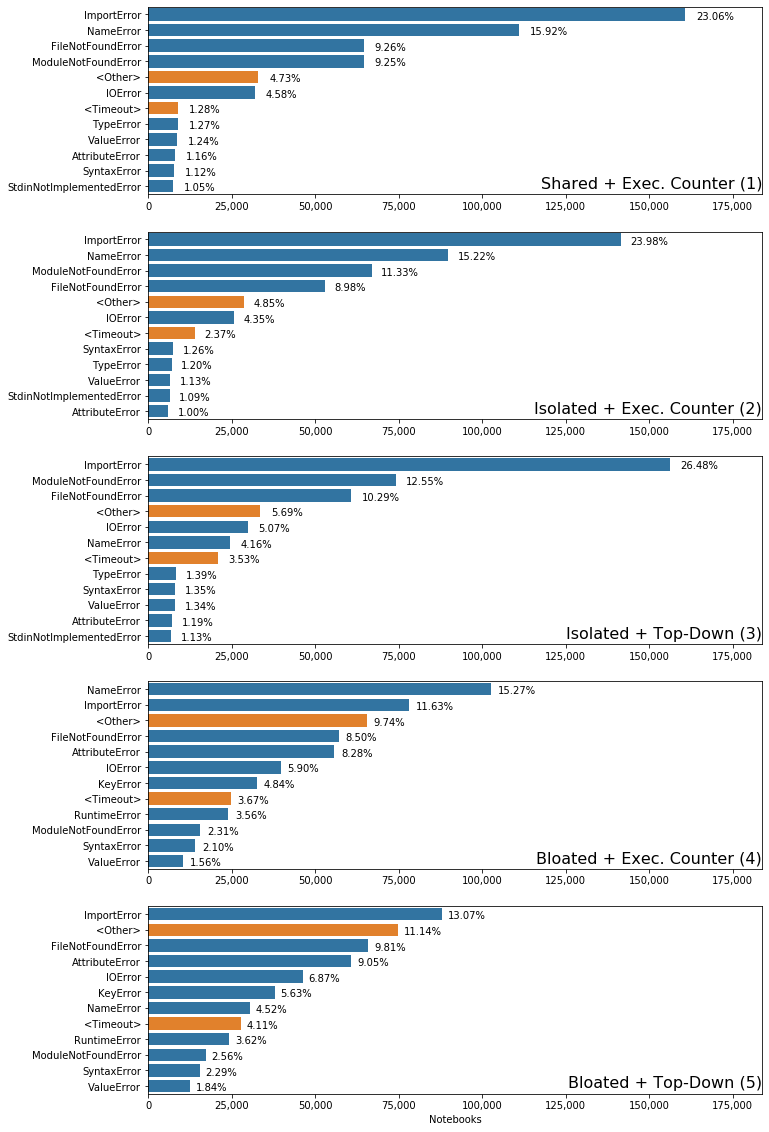

(Sample) 


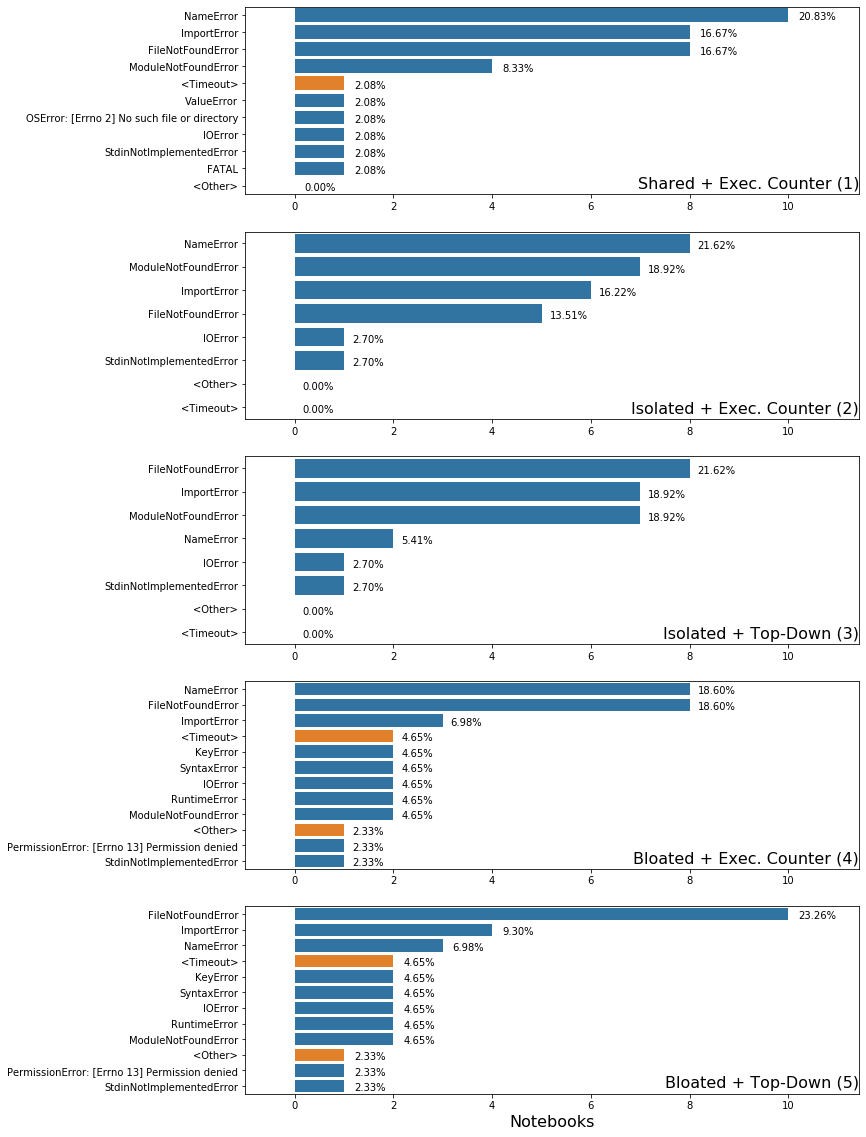

(Popular) 


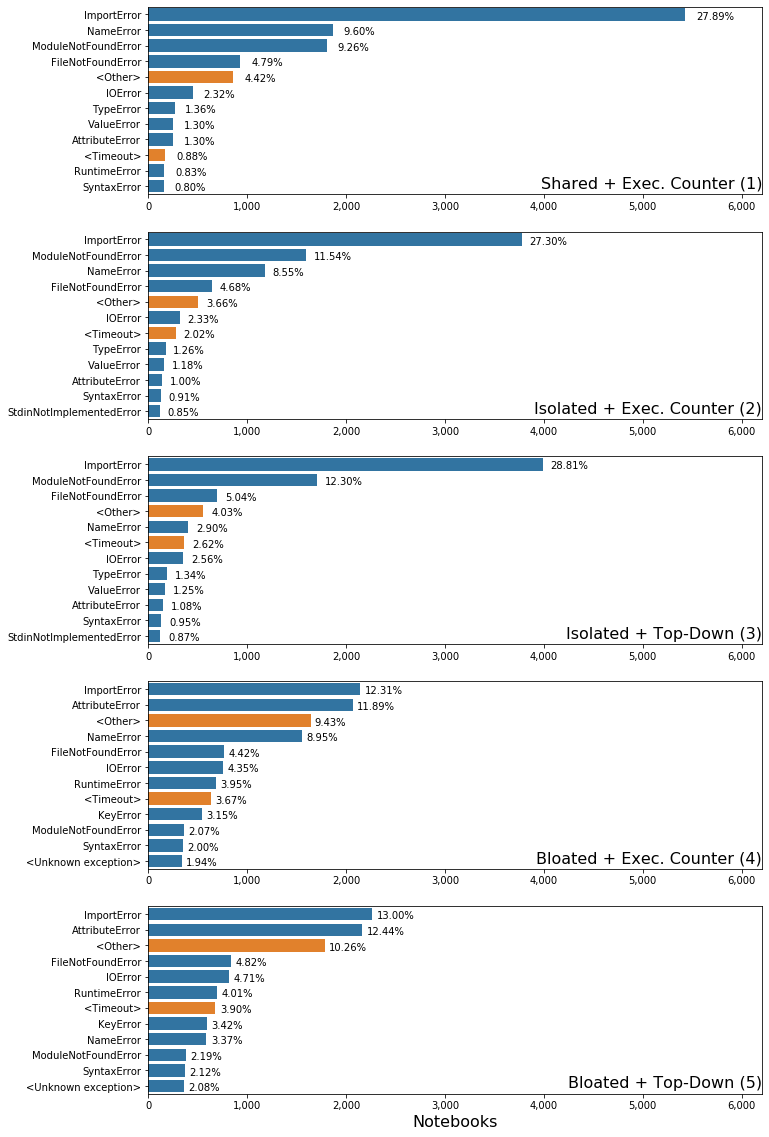

In [79]:
INDEX = sns.color_palette(n_colors=2)

def calculate_exception_reasons(data, prefix):
    modes, executed = data
    gcf, axes = plt.subplots(5, 1, sharex=True)
    with savefig(prefix + "a6_exception_reasons", 11, 20):
        max_total = 0
        for ax, (name, column, cvar, selection) in zip(axes, modes):
            total_executions = len(selection)
            counts = selection["{}_exception".format(column)].value_counts()
            del counts[""]
            counts = counts.sort_values(ascending=False)

            #_, cnt = display_counts(counts, show_values=True, plot=False, cut=)
            other = counts[slice(10, None)]
            counts = counts[slice(None, 10)]
            counts["<Timeout>"] = len(selection[selection["{}_timeout".format(column)]])
            counts["<Other>"] = other.sum()

            counts = counts.sort_values(ascending=False)
            elements = [[x] for x in counts.tolist()]
            #labels = [x.replace('Error', '') for x in counts.index.tolist()]
            labels = counts.index.tolist()
            position1 = labels.index("<Timeout>")
            position2 = labels.index("<Other>")
            colors = [INDEX[0] for _ in range(12)]
            colors[position1] = INDEX[1]
            colors[position2] = INDEX[1]
            ax = sns.barplot(data=elements, palette=colors, ax=ax, orient="h")
            ax.yaxis.set_ticklabels(labels, ha="right")
            for p in ax.patches:
                text = "{:.2%}".format(p.get_width() / executed[cvar])
                ax.annotate(text, (p.get_width() + elements[0][0] / 50, p.get_y() + 0.5), va="center", size=10)
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: "{0:,g}".format(x)))

            ax.set_title(name, position=(1, 0.0), ha="right")
            max_total = max(max_total, elements[0][0])
            ax.tick_params(axis='both', which='both', labelsize=10)
            ax.xaxis.set_tick_params(which='both', labelbottom=True)
        ax.set_xlim(-1, max_total + max_total / 7)
        ax.set_xlabel("Notebooks")
        #plt.tight_layout()

group_run(zip(modes, executed), DBMT, calculate_exception_reasons);

In [80]:
def calculate_module_exception(modes, prefix):
    module_exception = {}
    for name, column, cvar, selection in modes:
        module_exception[cvar] = selection[
            selection["{}_exception_meta_module_error".format(column)]
        ]
    return module_exception
            
module_exception = group_run(modes, DBMT, calculate_module_exception, plot=False);

In [81]:
def calculate_total_installed(modes, prefix):
    total_installed = {}
    for name, column, cvar, selection in modes:
        total_installed[cvar] = len(selection[
            selection["{}_installed_dependencies".format(column)]
        ])
    return total_installed
            
total_installed = group_run(modes, DBMT, calculate_total_installed, plot=False);

In [82]:
def calculate_total_non_installed(modes, prefix):
    total_non_installed = {}
    for name, column, cvar, selection in modes:
        total_non_installed[cvar] = len(selection[
            selection["{}_skipped_dependency_installation".format(column)]
        ])
    return total_non_installed
            
total_non_installed = group_run(modes, DBMT, calculate_total_non_installed, plot=False);

In [83]:
def calculate_in_installed(data, prefix):
    modes, module_exception = data
    in_installed = {}
    for name, column, cvar, selection in modes:
        in_installed[cvar] = len(module_exception[cvar][
            module_exception[cvar]["{}_installed_dependencies".format(column)]
        ])
    return in_installed
            
in_installed = group_run(zip(modes, module_exception), DBMT, calculate_in_installed, plot=False);

In [84]:
def calculate_in_non_installed(data, prefix):
    modes, module_exception = data
    in_non_installed = {}
    for name, column, cvar, selection in modes:
        in_non_installed[cvar] = len(module_exception[cvar][
            module_exception[cvar]["{}_skipped_dependency_installation".format(column)]
        ])
    return in_non_installed
            
in_non_installed = group_run(zip(modes, module_exception), DBMT, calculate_in_non_installed, plot=False);

In [85]:
for name, cvar in exec_modes:
    if total_installed[0][cvar]:
        dbmt_relative_var(
            "[{}] Module exception in installed: {{}}".format(name),
            "a6_execution_{}_module_exception_in_installed".format(cvar),
            in_installed, total_installed,
            fn=lambda x: x[cvar],
            fn2=lambda x: x[cvar],
        )

[Shared + Exec. Counter (1)] Module exception in installed: a6_execution_original_module_exception_in_installed


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"16,933 (44.18%)",None,None,None,None,None
1,(Sample),sd_,1 (33.33%),0.01%,0.00%,75.46%,(-) 24.54%,-10.84%
2,(Popular),td_,"1,002 (49.80%)",5.92%,2.61%,112.73%,(+) 12.73%,5.63%


In [86]:
for name, cvar in exec_modes:
    dbmt_relative_var(
        "[{}] Module exception in non installed: {{}}".format(name),
        "a6_execution_{}_module_exception_in_non_installed".format(cvar),
        in_non_installed, total_non_installed,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar],
    )

[Shared + Exec. Counter (1)] Module exception in non installed: a6_execution_original_module_exception_in_non_installed


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"208,345 (31.61%)",None,None,None,None,None
1,(Sample),sd_,11 (24.44%),0.01%,0.00%,77.33%,(-) 22.67%,-7.17%
2,(Popular),td_,"6,233 (35.70%)",2.99%,0.95%,112.92%,(+) 12.92%,4.08%


[Isolated + Exec. Counter (2)] Module exception in non installed: a6_execution_execorder_module_exception_in_non_installed


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"208,440 (35.31%)",None,None,None,None,None
1,(Sample),sd_,13 (35.14%),0.01%,0.00%,99.51%,(-) 0.49%,-0.17%
2,(Popular),td_,"5,376 (38.84%)",2.58%,0.91%,110.00%,(+) 10.00%,3.53%


[Isolated + Top-Down (3)] Module exception in non installed: a6_execution_topdown_module_exception_in_non_installed


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"230,365 (39.02%)",None,None,None,None,None
1,(Sample),sd_,14 (37.84%),0.01%,0.00%,96.97%,(-) 3.03%,-1.18%
2,(Popular),td_,"5,690 (41.11%)",2.47%,0.96%,105.34%,(+) 5.34%,2.09%


[Bloated + Exec. Counter (4)] Module exception in non installed: a6_execution_fullexecorder_module_exception_in_non_installed


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"93,685 (13.94%)",None,None,None,None,None
1,(Sample),sd_,5 (11.63%),0.01%,0.00%,83.44%,(-) 16.56%,-2.31%
2,(Popular),td_,"2,503 (14.38%)",2.67%,0.37%,103.15%,(+) 3.15%,0.44%


[Bloated + Top-Down (5)] Module exception in non installed: a6_execution_fulltopdown_module_exception_in_non_installed


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"105,090 (15.63%)",None,None,None,None,None
1,(Sample),sd_,6 (13.95%),0.01%,0.00%,89.26%,(-) 10.74%,-1.68%
2,(Popular),td_,"2,645 (15.19%)",2.52%,0.39%,97.18%,(-) 2.82%,-0.44%


In [87]:
def calculate_finished(data, prefix):
    modes, executed = data
    finished = {}
    for name, column, cvar, selection in modes:
        finished[cvar] = len(selection[
            selection["{}_run_all_cells".format(column)]
        ])
    return finished
finished = group_run(zip(modes, executed), DBMT, calculate_finished, plot=False);

In [88]:
for name, cvar in exec_modes:
    dbmt_relative_var(
        "[{}] Executed Notebooks: {{}}".format(name),
        "a6_execution_{}_repro_finished".format(cvar),
        finished, executed,
        fn=lambda x: x[cvar],
        fn2=lambda x: x[cvar],
    )

[Shared + Exec. Counter (1)] Executed Notebooks: a6_execution_original_repro_finished


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"181,955 (26.09%)",None,None,None,None,None
1,(Sample),sd_,12 (25.00%),0.01%,0.00%,95.82%,(-) 4.18%,-1.09%
2,(Popular),td_,"6,864 (35.25%)",3.77%,0.98%,135.10%,(+) 35.10%,9.16%


[Isolated + Exec. Counter (2)] Executed Notebooks: a6_execution_execorder_repro_finished


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"137,208 (23.24%)",None,None,None,None,None
1,(Sample),sd_,9 (24.32%),0.01%,0.00%,104.66%,(+) 4.66%,1.08%
2,(Popular),td_,"4,806 (34.72%)",3.50%,0.81%,149.39%,(+) 49.39%,11.48%


[Isolated + Top-Down (3)] Executed Notebooks: a6_execution_topdown_repro_finished


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"152,555 (25.84%)",None,None,None,None,None
1,(Sample),sd_,11 (29.73%),0.01%,0.00%,115.05%,(+) 15.05%,3.89%
2,(Popular),td_,"5,021 (36.27%)",3.29%,0.85%,140.37%,(+) 40.37%,10.43%


[Bloated + Exec. Counter (4)] Executed Notebooks: a6_execution_fullexecorder_repro_finished


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"151,730 (22.57%)",None,None,None,None,None
1,(Sample),sd_,9 (20.93%),0.01%,0.00%,92.73%,(-) 7.27%,-1.64%
2,(Popular),td_,"5,543 (31.84%)",3.65%,0.82%,141.05%,(+) 41.05%,9.27%


[Bloated + Top-Down (5)] Executed Notebooks: a6_execution_fulltopdown_repro_finished


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"170,949 (25.43%)",None,None,None,None,None
1,(Sample),sd_,11 (25.58%),0.01%,0.00%,100.60%,(+) 0.60%,0.15%
2,(Popular),td_,"5,858 (33.65%)",3.43%,0.87%,132.31%,(+) 32.31%,8.22%


In [89]:
normalizations = [
    ["No normalization", "original"],
    ["Encode", "encode"],
    ["Execution counter", "execution_count"],
    ["Stream", "stream"],
    ["Dictionary", "setdict"],
    ["Dataframe", "dataframe"],
    ["Exception path", "exception_path"],
    ["Deprecation", "deprecated"],
    ["White space", "whitespace"],
    ["Decimal", "decimal"],
    ["Date", "date"],
    ["Time", "time"],
    ["Memory", "memory"],
    ["Image", "image"],
]

def calculate_normalizations(data, prefix):
    modes, executed = data
    normalization_results = []
    normalization_same = {}
    normalization_distinct = {}
    for norm, normcolumn in normalizations:
        line = [norm]
        normalization_same[normcolumn] = {}
        normalization_distinct[normcolumn] = {}
    
        for name, column, cvar, selection in modes:
            if column == "original_exe" and normcolumn != "original":
                line.append("")
                continue
            normalization_same[normcolumn][cvar] = len(selection[
                selection["{}_{}_same_results".format(column, normcolumn)]
            ])
            normalization_distinct[normcolumn][cvar] = len(selection[
                selection["{}_{}_distinct_results".format(column, normcolumn)]
            ])
            relative_text = "{0:.2%}".format(
                normalization_same[normcolumn][cvar] / executed[cvar]
            )
            part_text = "{:,}".format(normalization_same[normcolumn][cvar])
            result_same = "{} ({})".format(part_text, relative_text)
            line.append(result_same)
        normalization_results.append(line)
    return normalization_results, normalization_same, normalization_distinct

normalization_results, normalization_same, normalization_distinct = list(zip(
    *group_run(zip(modes, executed), DBMT, calculate_normalizations, plot=False)
))

In [90]:
for norm, normcolumn in normalizations:
    for name, cvar in exec_modes:
        if cvar == "original" and normcolumn != "original":
            continue
        dbmt_relative_var(
            "[{} / {}] Same results: {{}}".format(norm, name),
            "a6_execution_{}_repro_same_{}".format(cvar, normcolumn),
            normalization_same, executed,
            fn=lambda x: x[normcolumn][cvar],
            fn2=lambda x: x[cvar],
        )

[No normalization / Shared + Exec. Counter (1)] Same results: a6_execution_original_repro_same_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"34,148 (4.90%)",None,None,None,None,None
1,(Sample),sd_,4 (8.33%),0.01%,0.00%,170.19%,(+) 70.19%,3.44%
2,(Popular),td_,"2,135 (10.96%)",6.25%,0.31%,223.91%,(+) 123.91%,6.07%


[No normalization / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"29,927 (5.07%)",None,None,None,None,None
1,(Sample),sd_,4 (10.81%),0.01%,0.00%,213.26%,(+) 113.26%,5.74%
2,(Popular),td_,"1,610 (11.63%)",5.38%,0.27%,229.44%,(+) 129.44%,6.56%


[No normalization / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"33,555 (5.68%)",None,None,None,None,None
1,(Sample),sd_,4 (10.81%),0.01%,0.00%,190.20%,(+) 90.20%,5.13%
2,(Popular),td_,"1,652 (11.93%)",4.92%,0.28%,209.98%,(+) 109.98%,6.25%


[No normalization / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"58,365 (8.68%)",None,None,None,None,None
1,(Sample),sd_,7 (16.28%),0.01%,0.00%,187.50%,(+) 87.50%,7.60%
2,(Popular),td_,"2,590 (14.88%)",4.44%,0.39%,171.33%,(+) 71.33%,6.19%


[No normalization / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"58,910 (8.76%)",None,None,None,None,None
1,(Sample),sd_,7 (16.28%),0.01%,0.00%,185.76%,(+) 85.76%,7.52%
2,(Popular),td_,"2,609 (14.98%)",4.43%,0.39%,170.99%,(+) 70.99%,6.22%


[Encode / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_encode


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"29,927 (5.07%)",None,None,None,None,None
1,(Sample),sd_,4 (10.81%),0.01%,0.00%,213.26%,(+) 113.26%,5.74%
2,(Popular),td_,"1,610 (11.63%)",5.38%,0.27%,229.44%,(+) 129.44%,6.56%


[Encode / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_encode


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"33,555 (5.68%)",None,None,None,None,None
1,(Sample),sd_,4 (10.81%),0.01%,0.00%,190.20%,(+) 90.20%,5.13%
2,(Popular),td_,"1,652 (11.93%)",4.92%,0.28%,209.98%,(+) 109.98%,6.25%


[Encode / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_encode


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"58,365 (8.68%)",None,None,None,None,None
1,(Sample),sd_,7 (16.28%),0.01%,0.00%,187.50%,(+) 87.50%,7.60%
2,(Popular),td_,"2,590 (14.88%)",4.44%,0.39%,171.33%,(+) 71.33%,6.19%


[Encode / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_encode


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"58,910 (8.76%)",None,None,None,None,None
1,(Sample),sd_,7 (16.28%),0.01%,0.00%,185.76%,(+) 85.76%,7.52%
2,(Popular),td_,"2,609 (14.98%)",4.43%,0.39%,170.99%,(+) 70.99%,6.22%


[Execution counter / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_execution_count


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"39,976 (6.77%)",None,None,None,None,None
1,(Sample),sd_,4 (10.81%),0.01%,0.00%,159.65%,(+) 59.65%,4.04%
2,(Popular),td_,"1,769 (12.78%)",4.43%,0.30%,188.73%,(+) 88.73%,6.01%


[Execution counter / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_execution_count


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"44,618 (7.56%)",None,None,None,None,None
1,(Sample),sd_,4 (10.81%),0.01%,0.00%,143.04%,(+) 43.04%,3.25%
2,(Popular),td_,"1,821 (13.16%)",4.08%,0.31%,174.07%,(+) 74.07%,5.60%


[Execution counter / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_execution_count


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"70,050 (10.42%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,178.54%,(+) 78.54%,8.18%
2,(Popular),td_,"2,769 (15.90%)",3.95%,0.41%,152.62%,(+) 52.62%,5.48%


[Execution counter / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_execution_count


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"71,873 (10.69%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,174.01%,(+) 74.01%,7.91%
2,(Popular),td_,"2,801 (16.09%)",3.90%,0.42%,150.47%,(+) 50.47%,5.40%


[Stream / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_stream


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"42,306 (7.17%)",None,None,None,None,None
1,(Sample),sd_,4 (10.81%),0.01%,0.00%,150.86%,(+) 50.86%,3.64%
2,(Popular),td_,"2,097 (15.15%)",4.96%,0.36%,211.40%,(+) 111.40%,7.98%


[Stream / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_stream


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"47,274 (8.01%)",None,None,None,None,None
1,(Sample),sd_,4 (10.81%),0.01%,0.00%,135.01%,(+) 35.01%,2.80%
2,(Popular),td_,"2,142 (15.47%)",4.53%,0.36%,193.25%,(+) 93.25%,7.47%


[Stream / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_stream


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"72,449 (10.78%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,172.63%,(+) 72.63%,7.83%
2,(Popular),td_,"2,907 (16.70%)",4.01%,0.43%,154.92%,(+) 54.92%,5.92%


[Stream / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_stream


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"74,410 (11.07%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,168.08%,(+) 68.08%,7.54%
2,(Popular),td_,"2,935 (16.86%)",3.94%,0.44%,152.29%,(+) 52.29%,5.79%


[Dictionary / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_setdict


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"42,306 (7.17%)",None,None,None,None,None
1,(Sample),sd_,4 (10.81%),0.01%,0.00%,150.86%,(+) 50.86%,3.64%
2,(Popular),td_,"2,097 (15.15%)",4.96%,0.36%,211.40%,(+) 111.40%,7.98%


[Dictionary / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_setdict


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"47,426 (8.03%)",None,None,None,None,None
1,(Sample),sd_,4 (10.81%),0.01%,0.00%,134.57%,(+) 34.57%,2.78%
2,(Popular),td_,"2,146 (15.50%)",4.52%,0.36%,192.99%,(+) 92.99%,7.47%


[Dictionary / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_setdict


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"72,449 (10.78%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,172.63%,(+) 72.63%,7.83%
2,(Popular),td_,"2,907 (16.70%)",4.01%,0.43%,154.92%,(+) 54.92%,5.92%


[Dictionary / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_setdict


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"74,410 (11.07%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,168.08%,(+) 68.08%,7.54%
2,(Popular),td_,"2,935 (16.86%)",3.94%,0.44%,152.29%,(+) 52.29%,5.79%


[Dataframe / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_dataframe


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"45,773 (7.75%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,174.29%,(+) 74.29%,5.76%
2,(Popular),td_,"2,189 (15.81%)",4.78%,0.37%,203.96%,(+) 103.96%,8.06%


[Dataframe / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_dataframe


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"51,357 (8.70%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,155.34%,(+) 55.34%,4.81%
2,(Popular),td_,"2,243 (16.20%)",4.37%,0.38%,186.27%,(+) 86.27%,7.51%


[Dataframe / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_dataframe


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"75,708 (11.26%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,165.20%,(+) 65.20%,7.34%
2,(Popular),td_,"2,999 (17.22%)",3.96%,0.45%,152.94%,(+) 52.94%,5.96%


[Dataframe / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_dataframe


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"77,990 (11.60%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,160.36%,(+) 60.36%,7.00%
2,(Popular),td_,"3,029 (17.40%)",3.88%,0.45%,149.95%,(+) 49.95%,5.80%


[Exception path / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_exception_path


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"45,773 (7.75%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,174.29%,(+) 74.29%,5.76%
2,(Popular),td_,"2,189 (15.81%)",4.78%,0.37%,203.96%,(+) 103.96%,8.06%


[Exception path / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_exception_path


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"51,415 (8.71%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,155.17%,(+) 55.17%,4.80%
2,(Popular),td_,"2,243 (16.20%)",4.36%,0.38%,186.06%,(+) 86.06%,7.50%


[Exception path / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_exception_path


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"75,708 (11.26%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,165.20%,(+) 65.20%,7.34%
2,(Popular),td_,"2,999 (17.22%)",3.96%,0.45%,152.94%,(+) 52.94%,5.96%


[Exception path / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_exception_path


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"77,990 (11.60%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,160.36%,(+) 60.36%,7.00%
2,(Popular),td_,"3,029 (17.40%)",3.88%,0.45%,149.95%,(+) 49.95%,5.80%


[Deprecation / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_deprecated


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"48,138 (8.15%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,165.73%,(+) 65.73%,5.36%
2,(Popular),td_,"2,249 (16.25%)",4.67%,0.38%,199.26%,(+) 99.26%,8.09%


[Deprecation / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_deprecated


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"54,058 (9.16%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,147.58%,(+) 47.58%,4.36%
2,(Popular),td_,"2,310 (16.69%)",4.27%,0.39%,182.25%,(+) 82.25%,7.53%


[Deprecation / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_deprecated


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"79,763 (11.87%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,156.80%,(+) 56.80%,6.74%
2,(Popular),td_,"3,098 (17.79%)",3.88%,0.46%,149.96%,(+) 49.96%,5.93%


[Deprecation / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_deprecated


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"82,370 (12.25%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,151.84%,(+) 51.84%,6.35%
2,(Popular),td_,"3,134 (18.00%)",3.80%,0.47%,146.90%,(+) 46.90%,5.75%


[White space / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_whitespace


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"48,138 (8.15%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,165.73%,(+) 65.73%,5.36%
2,(Popular),td_,"2,249 (16.25%)",4.67%,0.38%,199.26%,(+) 99.26%,8.09%


[White space / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_whitespace


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"54,593 (9.25%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,146.13%,(+) 46.13%,4.27%
2,(Popular),td_,"2,332 (16.85%)",4.27%,0.40%,182.18%,(+) 82.18%,7.60%


[White space / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_whitespace


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"79,763 (11.87%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,156.80%,(+) 56.80%,6.74%
2,(Popular),td_,"3,098 (17.79%)",3.88%,0.46%,149.96%,(+) 49.96%,5.93%


[White space / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_whitespace


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"82,370 (12.25%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,151.84%,(+) 51.84%,6.35%
2,(Popular),td_,"3,134 (18.00%)",3.80%,0.47%,146.90%,(+) 46.90%,5.75%


[Decimal / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_decimal


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"48,138 (8.15%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,165.73%,(+) 65.73%,5.36%
2,(Popular),td_,"2,249 (16.25%)",4.67%,0.38%,199.26%,(+) 99.26%,8.09%


[Decimal / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_decimal


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"55,161 (9.34%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,144.63%,(+) 44.63%,4.17%
2,(Popular),td_,"2,343 (16.93%)",4.25%,0.40%,181.16%,(+) 81.16%,7.58%


[Decimal / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_decimal


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"79,763 (11.87%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,156.80%,(+) 56.80%,6.74%
2,(Popular),td_,"3,098 (17.79%)",3.88%,0.46%,149.96%,(+) 49.96%,5.93%


[Decimal / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_decimal


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"82,370 (12.25%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,151.84%,(+) 51.84%,6.35%
2,(Popular),td_,"3,134 (18.00%)",3.80%,0.47%,146.90%,(+) 46.90%,5.75%


[Date / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_date


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"48,138 (8.15%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,165.73%,(+) 65.73%,5.36%
2,(Popular),td_,"2,249 (16.25%)",4.67%,0.38%,199.26%,(+) 99.26%,8.09%


[Date / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_date


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"55,174 (9.35%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,144.59%,(+) 44.59%,4.17%
2,(Popular),td_,"2,343 (16.93%)",4.25%,0.40%,181.12%,(+) 81.12%,7.58%


[Date / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_date


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"79,763 (11.87%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,156.80%,(+) 56.80%,6.74%
2,(Popular),td_,"3,098 (17.79%)",3.88%,0.46%,149.96%,(+) 49.96%,5.93%


[Date / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_date


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"82,370 (12.25%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,151.84%,(+) 51.84%,6.35%
2,(Popular),td_,"3,134 (18.00%)",3.80%,0.47%,146.90%,(+) 46.90%,5.75%


[Time / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_time


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"48,138 (8.15%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,165.73%,(+) 65.73%,5.36%
2,(Popular),td_,"2,249 (16.25%)",4.67%,0.38%,199.26%,(+) 99.26%,8.09%


[Time / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_time


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"55,183 (9.35%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,144.57%,(+) 44.57%,4.17%
2,(Popular),td_,"2,343 (16.93%)",4.25%,0.40%,181.09%,(+) 81.09%,7.58%


[Time / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_time


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"79,763 (11.87%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,156.80%,(+) 56.80%,6.74%
2,(Popular),td_,"3,098 (17.79%)",3.88%,0.46%,149.96%,(+) 49.96%,5.93%


[Time / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_time


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"82,370 (12.25%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,151.84%,(+) 51.84%,6.35%
2,(Popular),td_,"3,134 (18.00%)",3.80%,0.47%,146.90%,(+) 46.90%,5.75%


[Memory / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_memory


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"48,138 (8.15%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,165.73%,(+) 65.73%,5.36%
2,(Popular),td_,"2,249 (16.25%)",4.67%,0.38%,199.26%,(+) 99.26%,8.09%


[Memory / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_memory


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"55,404 (9.38%)",None,None,None,None,None
1,(Sample),sd_,5 (13.51%),0.01%,0.00%,143.99%,(+) 43.99%,4.13%
2,(Popular),td_,"2,347 (16.96%)",4.24%,0.40%,180.67%,(+) 80.67%,7.57%


[Memory / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_memory


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"79,763 (11.87%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,156.80%,(+) 56.80%,6.74%
2,(Popular),td_,"3,098 (17.79%)",3.88%,0.46%,149.96%,(+) 49.96%,5.93%


[Memory / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_memory


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"82,370 (12.25%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,151.84%,(+) 51.84%,6.35%
2,(Popular),td_,"3,134 (18.00%)",3.80%,0.47%,146.90%,(+) 46.90%,5.75%


[Image / Isolated + Exec. Counter (2)] Same results: a6_execution_execorder_repro_same_image


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"64,214 (10.88%)",None,None,None,None,None
1,(Sample),sd_,6 (16.22%),0.01%,0.00%,149.08%,(+) 49.08%,5.34%
2,(Popular),td_,"2,678 (19.35%)",4.17%,0.45%,177.87%,(+) 77.87%,8.47%


[Image / Isolated + Top-Down (3)] Same results: a6_execution_topdown_repro_same_image


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"76,745 (13.00%)",None,None,None,None,None
1,(Sample),sd_,6 (16.22%),0.01%,0.00%,124.74%,(+) 24.74%,3.22%
2,(Popular),td_,"2,846 (20.56%)",3.71%,0.48%,158.16%,(+) 58.16%,7.56%


[Image / Bloated + Exec. Counter (4)] Same results: a6_execution_fullexecorder_repro_same_image


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"96,783 (14.40%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,129.22%,(+) 29.22%,4.21%
2,(Popular),td_,"3,641 (20.91%)",3.76%,0.54%,145.25%,(+) 45.25%,6.51%


[Image / Bloated + Top-Down (5)] Same results: a6_execution_fulltopdown_repro_same_image


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"101,078 (15.04%)",None,None,None,None,None
1,(Sample),sd_,8 (18.60%),0.01%,0.00%,123.73%,(+) 23.73%,3.57%
2,(Popular),td_,"3,712 (21.32%)",3.67%,0.55%,141.79%,(+) 41.79%,6.28%


In [91]:
for norm, normcolumn in normalizations:
    for name, cvar in exec_modes:
        if cvar == "original" and normcolumn != "original":
            continue
        dbmt_relative_var(
            "[{} / {}] Distinct results: {{}}".format(norm, name),
            "a6_execution_{}_repro_distinct_{}".format(cvar, normcolumn),
            normalization_distinct, executed,
            fn=lambda x: x[normcolumn][cvar],
            fn2=lambda x: x[cvar],
        )

[No normalization / Shared + Exec. Counter (1)] Distinct results: a6_execution_original_repro_distinct_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"697,397 (100.00%)",None,None,None,None,None
1,(Sample),sd_,48 (100.00%),0.01%,0.01%,100.00%,(+) 0.00%,0.00%
2,(Popular),td_,"19,473 (100.00%)",2.79%,2.79%,100.00%,(+) 0.00%,0.00%


[No normalization / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"560,427 (94.93%)",None,None,None,None,None
1,(Sample),sd_,33 (89.19%),0.01%,0.01%,93.95%,(-) 6.05%,-5.74%
2,(Popular),td_,"12,232 (88.37%)",2.18%,2.07%,93.09%,(-) 6.91%,-6.56%


[No normalization / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"556,803 (94.32%)",None,None,None,None,None
1,(Sample),sd_,33 (89.19%),0.01%,0.01%,94.56%,(-) 5.44%,-5.13%
2,(Popular),td_,"12,190 (88.07%)",2.19%,2.06%,93.37%,(-) 6.63%,-6.25%


[No normalization / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"613,351 (91.24%)",None,None,None,None,None
1,(Sample),sd_,36 (83.72%),0.01%,0.01%,91.76%,(-) 8.24%,-7.52%
2,(Popular),td_,"14,816 (85.10%)",2.42%,2.20%,93.26%,(-) 6.74%,-6.15%


[No normalization / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"613,014 (91.19%)",None,None,None,None,None
1,(Sample),sd_,36 (83.72%),0.01%,0.01%,91.81%,(-) 8.19%,-7.47%
2,(Popular),td_,"14,797 (84.99%)",2.41%,2.20%,93.20%,(-) 6.80%,-6.20%


[Encode / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_encode


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"560,427 (94.93%)",None,None,None,None,None
1,(Sample),sd_,33 (89.19%),0.01%,0.01%,93.95%,(-) 6.05%,-5.74%
2,(Popular),td_,"12,232 (88.37%)",2.18%,2.07%,93.09%,(-) 6.91%,-6.56%


[Encode / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_encode


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"556,803 (94.32%)",None,None,None,None,None
1,(Sample),sd_,33 (89.19%),0.01%,0.01%,94.56%,(-) 5.44%,-5.13%
2,(Popular),td_,"12,190 (88.07%)",2.19%,2.06%,93.37%,(-) 6.63%,-6.25%


[Encode / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_encode


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"613,351 (91.24%)",None,None,None,None,None
1,(Sample),sd_,36 (83.72%),0.01%,0.01%,91.76%,(-) 8.24%,-7.52%
2,(Popular),td_,"14,816 (85.10%)",2.42%,2.20%,93.26%,(-) 6.74%,-6.15%


[Encode / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_encode


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"613,014 (91.19%)",None,None,None,None,None
1,(Sample),sd_,36 (83.72%),0.01%,0.01%,91.81%,(-) 8.19%,-7.47%
2,(Popular),td_,"14,797 (84.99%)",2.41%,2.20%,93.20%,(-) 6.80%,-6.20%


[Execution counter / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_execution_count


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"550,378 (93.23%)",None,None,None,None,None
1,(Sample),sd_,33 (89.19%),0.01%,0.01%,95.67%,(-) 4.33%,-4.04%
2,(Popular),td_,"12,073 (87.22%)",2.19%,2.05%,93.56%,(-) 6.44%,-6.01%


[Execution counter / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_execution_count


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"545,740 (92.44%)",None,None,None,None,None
1,(Sample),sd_,33 (89.19%),0.01%,0.01%,96.48%,(-) 3.52%,-3.25%
2,(Popular),td_,"12,021 (86.84%)",2.20%,2.04%,93.94%,(-) 6.06%,-5.60%


[Execution counter / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_execution_count


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"601,666 (89.50%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,90.94%,(-) 9.06%,-8.11%
2,(Popular),td_,"14,637 (84.07%)",2.43%,2.18%,93.93%,(-) 6.07%,-5.44%


[Execution counter / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_execution_count


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"600,051 (89.26%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,91.19%,(-) 8.81%,-7.87%
2,(Popular),td_,"14,605 (83.88%)",2.43%,2.17%,93.97%,(-) 6.03%,-5.38%


[Stream / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_stream


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"548,048 (92.83%)",None,None,None,None,None
1,(Sample),sd_,33 (89.19%),0.01%,0.01%,96.07%,(-) 3.93%,-3.64%
2,(Popular),td_,"11,745 (84.85%)",2.14%,1.99%,91.40%,(-) 8.60%,-7.98%


[Stream / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_stream


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"543,084 (91.99%)",None,None,None,None,None
1,(Sample),sd_,33 (89.19%),0.01%,0.01%,96.95%,(-) 3.05%,-2.80%
2,(Popular),td_,"11,700 (84.53%)",2.15%,1.98%,91.88%,(-) 8.12%,-7.47%


[Stream / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_stream


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"599,267 (89.15%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,91.31%,(-) 8.69%,-7.75%
2,(Popular),td_,"14,499 (83.27%)",2.42%,2.16%,93.41%,(-) 6.59%,-5.87%


[Stream / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_stream


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"597,514 (88.88%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,91.57%,(-) 8.43%,-7.49%
2,(Popular),td_,"14,471 (83.11%)",2.42%,2.15%,93.51%,(-) 6.49%,-5.77%


[Dictionary / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_setdict


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"548,048 (92.83%)",None,None,None,None,None
1,(Sample),sd_,33 (89.19%),0.01%,0.01%,96.07%,(-) 3.93%,-3.64%
2,(Popular),td_,"11,745 (84.85%)",2.14%,1.99%,91.40%,(-) 8.60%,-7.98%


[Dictionary / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_setdict


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"542,932 (91.97%)",None,None,None,None,None
1,(Sample),sd_,33 (89.19%),0.01%,0.01%,96.98%,(-) 3.02%,-2.78%
2,(Popular),td_,"11,696 (84.50%)",2.15%,1.98%,91.88%,(-) 8.12%,-7.47%


[Dictionary / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_setdict


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"599,267 (89.15%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,91.31%,(-) 8.69%,-7.75%
2,(Popular),td_,"14,499 (83.27%)",2.42%,2.16%,93.41%,(-) 6.59%,-5.87%


[Dictionary / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_setdict


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"597,514 (88.88%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,91.57%,(-) 8.43%,-7.49%
2,(Popular),td_,"14,471 (83.11%)",2.42%,2.15%,93.51%,(-) 6.49%,-5.77%


[Dataframe / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_dataframe


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"544,581 (92.25%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,93.76%,(-) 6.24%,-5.76%
2,(Popular),td_,"11,653 (84.19%)",2.14%,1.97%,91.26%,(-) 8.74%,-8.06%


[Dataframe / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_dataframe


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"539,001 (91.30%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,94.73%,(-) 5.27%,-4.81%
2,(Popular),td_,"11,599 (83.80%)",2.15%,1.96%,91.78%,(-) 8.22%,-7.51%


[Dataframe / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_dataframe


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"596,008 (88.66%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,91.81%,(-) 8.19%,-7.27%
2,(Popular),td_,"14,407 (82.75%)",2.42%,2.14%,93.33%,(-) 6.67%,-5.91%


[Dataframe / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_dataframe


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"593,934 (88.35%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.13%,(-) 7.87%,-6.96%
2,(Popular),td_,"14,377 (82.57%)",2.42%,2.14%,93.46%,(-) 6.54%,-5.78%


[Exception path / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_exception_path


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"544,581 (92.25%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,93.76%,(-) 6.24%,-5.76%
2,(Popular),td_,"11,653 (84.19%)",2.14%,1.97%,91.26%,(-) 8.74%,-8.06%


[Exception path / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_exception_path


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"538,943 (91.29%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,94.74%,(-) 5.26%,-4.80%
2,(Popular),td_,"11,599 (83.80%)",2.15%,1.96%,91.79%,(-) 8.21%,-7.50%


[Exception path / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_exception_path


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"596,008 (88.66%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,91.81%,(-) 8.19%,-7.27%
2,(Popular),td_,"14,407 (82.75%)",2.42%,2.14%,93.33%,(-) 6.67%,-5.91%


[Exception path / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_exception_path


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"593,934 (88.35%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.13%,(-) 7.87%,-6.96%
2,(Popular),td_,"14,377 (82.57%)",2.42%,2.14%,93.46%,(-) 6.54%,-5.78%


[Deprecation / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_deprecated


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"542,216 (91.85%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,94.16%,(-) 5.84%,-5.36%
2,(Popular),td_,"11,593 (83.75%)",2.14%,1.96%,91.19%,(-) 8.81%,-8.09%


[Deprecation / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_deprecated


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"536,300 (90.84%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,95.20%,(-) 4.80%,-4.36%
2,(Popular),td_,"11,532 (83.31%)",2.15%,1.95%,91.71%,(-) 8.29%,-7.53%


[Deprecation / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_deprecated


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"591,953 (88.06%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.43%,(-) 7.57%,-6.66%
2,(Popular),td_,"14,308 (82.18%)",2.42%,2.13%,93.32%,(-) 6.68%,-5.88%


[Deprecation / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_deprecated


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"589,554 (87.70%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.81%,(-) 7.19%,-6.31%
2,(Popular),td_,"14,272 (81.97%)",2.42%,2.12%,93.47%,(-) 6.53%,-5.73%


[White space / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_whitespace


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"542,216 (91.85%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,94.16%,(-) 5.84%,-5.36%
2,(Popular),td_,"11,593 (83.75%)",2.14%,1.96%,91.19%,(-) 8.81%,-8.09%


[White space / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_whitespace


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"535,765 (90.75%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,95.30%,(-) 4.70%,-4.27%
2,(Popular),td_,"11,510 (83.15%)",2.15%,1.95%,91.63%,(-) 8.37%,-7.60%


[White space / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_whitespace


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"591,953 (88.06%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.43%,(-) 7.57%,-6.66%
2,(Popular),td_,"14,308 (82.18%)",2.42%,2.13%,93.32%,(-) 6.68%,-5.88%


[White space / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_whitespace


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"589,554 (87.70%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.81%,(-) 7.19%,-6.31%
2,(Popular),td_,"14,272 (81.97%)",2.42%,2.12%,93.47%,(-) 6.53%,-5.73%


[Decimal / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_decimal


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"542,216 (91.85%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,94.16%,(-) 5.84%,-5.36%
2,(Popular),td_,"11,593 (83.75%)",2.14%,1.96%,91.19%,(-) 8.81%,-8.09%


[Decimal / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_decimal


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"535,197 (90.66%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,95.40%,(-) 4.60%,-4.17%
2,(Popular),td_,"11,499 (83.07%)",2.15%,1.95%,91.64%,(-) 8.36%,-7.58%


[Decimal / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_decimal


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"591,953 (88.06%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.43%,(-) 7.57%,-6.66%
2,(Popular),td_,"14,308 (82.18%)",2.42%,2.13%,93.32%,(-) 6.68%,-5.88%


[Decimal / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_decimal


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"589,554 (87.70%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.81%,(-) 7.19%,-6.31%
2,(Popular),td_,"14,272 (81.97%)",2.42%,2.12%,93.47%,(-) 6.53%,-5.73%


[Date / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_date


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"542,216 (91.85%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,94.16%,(-) 5.84%,-5.36%
2,(Popular),td_,"11,593 (83.75%)",2.14%,1.96%,91.19%,(-) 8.81%,-8.09%


[Date / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_date


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"535,184 (90.65%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,95.40%,(-) 4.60%,-4.17%
2,(Popular),td_,"11,499 (83.07%)",2.15%,1.95%,91.64%,(-) 8.36%,-7.58%


[Date / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_date


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"591,953 (88.06%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.43%,(-) 7.57%,-6.66%
2,(Popular),td_,"14,308 (82.18%)",2.42%,2.13%,93.32%,(-) 6.68%,-5.88%


[Date / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_date


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"589,554 (87.70%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.81%,(-) 7.19%,-6.31%
2,(Popular),td_,"14,272 (81.97%)",2.42%,2.12%,93.47%,(-) 6.53%,-5.73%


[Time / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_time


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"542,216 (91.85%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,94.16%,(-) 5.84%,-5.36%
2,(Popular),td_,"11,593 (83.75%)",2.14%,1.96%,91.19%,(-) 8.81%,-8.09%


[Time / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_time


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"535,175 (90.65%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,95.40%,(-) 4.60%,-4.17%
2,(Popular),td_,"11,499 (83.07%)",2.15%,1.95%,91.64%,(-) 8.36%,-7.58%


[Time / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_time


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"591,953 (88.06%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.43%,(-) 7.57%,-6.66%
2,(Popular),td_,"14,308 (82.18%)",2.42%,2.13%,93.32%,(-) 6.68%,-5.88%


[Time / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_time


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"589,554 (87.70%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.81%,(-) 7.19%,-6.31%
2,(Popular),td_,"14,272 (81.97%)",2.42%,2.12%,93.47%,(-) 6.53%,-5.73%


[Memory / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_memory


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"542,216 (91.85%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,94.16%,(-) 5.84%,-5.36%
2,(Popular),td_,"11,593 (83.75%)",2.14%,1.96%,91.19%,(-) 8.81%,-8.09%


[Memory / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_memory


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"534,954 (90.62%)",None,None,None,None,None
1,(Sample),sd_,32 (86.49%),0.01%,0.01%,95.44%,(-) 4.56%,-4.13%
2,(Popular),td_,"11,495 (83.04%)",2.15%,1.95%,91.65%,(-) 8.35%,-7.57%


[Memory / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_memory


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"591,953 (88.06%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.43%,(-) 7.57%,-6.66%
2,(Popular),td_,"14,308 (82.18%)",2.42%,2.13%,93.32%,(-) 6.68%,-5.88%


[Memory / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_memory


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"589,554 (87.70%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,92.81%,(-) 7.19%,-6.31%
2,(Popular),td_,"14,272 (81.97%)",2.42%,2.12%,93.47%,(-) 6.53%,-5.73%


[Image / Isolated + Exec. Counter (2)] Distinct results: a6_execution_execorder_repro_distinct_image


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"526,140 (89.12%)",None,None,None,None,None
1,(Sample),sd_,31 (83.78%),0.01%,0.01%,94.01%,(-) 5.99%,-5.34%
2,(Popular),td_,"11,164 (80.65%)",2.12%,1.89%,90.50%,(-) 9.50%,-8.47%


[Image / Isolated + Top-Down (3)] Distinct results: a6_execution_topdown_repro_distinct_image


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"513,613 (87.00%)",None,None,None,None,None
1,(Sample),sd_,31 (83.78%),0.01%,0.01%,96.30%,(-) 3.70%,-3.22%
2,(Popular),td_,"10,996 (79.44%)",2.14%,1.86%,91.31%,(-) 8.69%,-7.56%


[Image / Bloated + Exec. Counter (4)] Distinct results: a6_execution_fullexecorder_repro_distinct_image


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"574,933 (85.53%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,95.17%,(-) 4.83%,-4.13%
2,(Popular),td_,"13,765 (79.06%)",2.39%,2.05%,92.44%,(-) 7.56%,-6.47%


[Image / Bloated + Top-Down (5)] Distinct results: a6_execution_fulltopdown_repro_distinct_image


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"570,846 (84.92%)",None,None,None,None,None
1,(Sample),sd_,35 (81.40%),0.01%,0.01%,95.85%,(-) 4.15%,-3.52%
2,(Popular),td_,"13,694 (78.65%)",2.40%,2.04%,92.62%,(-) 7.38%,-6.27%


In [92]:
result = group_run(normalization_results, DBMT, lambda normalization_results, prefix:pd.DataFrame.from_records(normalization_results), plot=False)
for res in result:
    display(res)

,0,1,2,3,4,5
0,No normalization,"34,148 (4.90%)","29,927 (5.07%)","33,555 (5.68%)","58,365 (8.68%)","58,910 (8.76%)"
1,Encode,,"29,927 (5.07%)","33,555 (5.68%)","58,365 (8.68%)","58,910 (8.76%)"
2,Execution counter,,"39,976 (6.77%)","44,618 (7.56%)","70,050 (10.42%)","71,873 (10.69%)"
3,Stream,,"42,306 (7.17%)","47,274 (8.01%)","72,449 (10.78%)","74,410 (11.07%)"
4,Dictionary,,"42,306 (7.17%)","47,426 (8.03%)","72,449 (10.78%)","74,410 (11.07%)"
5,Dataframe,,"45,773 (7.75%)","51,357 (8.70%)","75,708 (11.26%)","77,990 (11.60%)"
6,Exception path,,"45,773 (7.75%)","51,415 (8.71%)","75,708 (11.26%)","77,990 (11.60%)"
7,Deprecation,,"48,138 (8.15%)","54,058 (9.16%)","79,763 (11.87%)","82,370 (12.25%)"
8,White space,,"48,138 (8.15%)","54,593 (9.25%)","79,763 (11.87%)","82,370 (12.25%)"
9,Decimal,,"48,138 (8.15%)","55,161 (9.34%)","79,763 (11.87%)","82,370 (12.25%)"


,0,1,2,3,4,5
0,No normalization,4 (8.33%),4 (10.81%),4 (10.81%),7 (16.28%),7 (16.28%)
1,Encode,,4 (10.81%),4 (10.81%),7 (16.28%),7 (16.28%)
2,Execution counter,,4 (10.81%),4 (10.81%),8 (18.60%),8 (18.60%)
3,Stream,,4 (10.81%),4 (10.81%),8 (18.60%),8 (18.60%)
4,Dictionary,,4 (10.81%),4 (10.81%),8 (18.60%),8 (18.60%)
5,Dataframe,,5 (13.51%),5 (13.51%),8 (18.60%),8 (18.60%)
6,Exception path,,5 (13.51%),5 (13.51%),8 (18.60%),8 (18.60%)
7,Deprecation,,5 (13.51%),5 (13.51%),8 (18.60%),8 (18.60%)
8,White space,,5 (13.51%),5 (13.51%),8 (18.60%),8 (18.60%)
9,Decimal,,5 (13.51%),5 (13.51%),8 (18.60%),8 (18.60%)


,0,1,2,3,4,5
0,No normalization,"2,135 (10.96%)","1,610 (11.63%)","1,652 (11.93%)","2,590 (14.88%)","2,609 (14.98%)"
1,Encode,,"1,610 (11.63%)","1,652 (11.93%)","2,590 (14.88%)","2,609 (14.98%)"
2,Execution counter,,"1,769 (12.78%)","1,821 (13.16%)","2,769 (15.90%)","2,801 (16.09%)"
3,Stream,,"2,097 (15.15%)","2,142 (15.47%)","2,907 (16.70%)","2,935 (16.86%)"
4,Dictionary,,"2,097 (15.15%)","2,146 (15.50%)","2,907 (16.70%)","2,935 (16.86%)"
5,Dataframe,,"2,189 (15.81%)","2,243 (16.20%)","2,999 (17.22%)","3,029 (17.40%)"
6,Exception path,,"2,189 (15.81%)","2,243 (16.20%)","2,999 (17.22%)","3,029 (17.40%)"
7,Deprecation,,"2,249 (16.25%)","2,310 (16.69%)","3,098 (17.79%)","3,134 (18.00%)"
8,White space,,"2,249 (16.25%)","2,332 (16.85%)","3,098 (17.79%)","3,134 (18.00%)"
9,Decimal,,"2,249 (16.25%)","2,343 (16.93%)","3,098 (17.79%)","3,134 (18.00%)"


In [93]:
notebooks_with_exception

,id
0,1451214
1,1236597
2,638813
3,348225
4,279604
...,...
91358,936529
91359,1521542
91360,946088
91361,606184


In [94]:
def create_normalization_tex(data, prefix):
    modes, normalization_results, executed, finished = data
    latex_norm = " \\\\ \n".join(
        " & ".join(    
            "\makecell{%s}" % (element.replace(" (", r"\\ ("),) if i else "\makecell[l]{%s}" % (element.replace(" ", r" \\ "),)
            for i, element in enumerate(line)
        ) for line in normalization_results
    ).replace('%', '\\%')

    output_after_exception = []
    for name, column, cvar, selection in modes:
        if "topdown" in cvar:
            execution_after_exception = topdown_notebooks_with_execution_after_exception
        else:
            execution_after_exception = execorder_notebooks_with_execution_after_exception
        selection_count = len(selection[
            (selection["{}_exception".format(column)] != "")
            & (selection['id'].isin(execution_after_exception['id']))
        ])
        output_after_exception.append("\makecell{{{:,} \\\\ ({:.2%})}}".format(
            selection_count,
            selection_count / executed[cvar]
        ).replace('%', '\\%'))
        
    had_exception_originally = []
    for name, column, cvar, selection in modes:
        selection_count = len(selection[
            (selection["{}_exception".format(column)] != "")
            & (selection['id'].isin(notebooks_with_exception['id']))
        ])
        had_exception_originally.append("\makecell{{{:,} \\\\ ({:.2%})}}".format(
            selection_count,
            selection_count / executed[cvar]
        ).replace('%', '\\%'))
    
    latex = r"""
    \begin{tabular}{>{\raggedright}p{20mm}ccccc}
      \toprule
       & \thead{ Shared + \\ Exec. \\ Counter (1)} & \thead{Isolated + \\ Exec. \\ Counter (2)} & \thead{Isolated + \\ Top \\ Down (3)} & \thead{Bloated + \\ Exec. \\ Counter (4)} & \thead{Bloated + \\ Top \\ Down (5)} \\
      \midrule

       \makecell[l]{Attempted \\ executions} & %s \\
       \makecell[l]{Run all \\ cells} & %s \\
       \makecell[l]{Stopped by \\ timeout} & %s \\
       \makecell[l]{Stopped by \\ exception} & %s \\
       \makecell[l]{Had exception \\ originally} & %s \\
       \makecell[l]{Output after \\ exception} & %s \\
      \midrule
      \textbf{Same results} & & & & & \\
      %s
      \\
      \bottomrule
    \end{tabular}
    """ % (
        " & ".join(
            "{:,}".format(executed[cvar])
            for name, column, cvar, selection in modes
        ),
        " & ".join(
            "\makecell{{{:,} \\\\ ({:.2%})}}".format(
                finished[cvar],
                finished[cvar] / executed[cvar],

            ).replace('%', '\\%')
            for name, column, cvar, selection in modes
        ),
        " & ".join(
            "\makecell{{{:,} \\\\ ({:.2%})}}".format(
                len(selection[selection["{}_timeout".format(column)]]),
                len(selection[selection["{}_timeout".format(column)]])
                / executed[cvar],

            ).replace('%', '\\%')
            for name, column, cvar, selection in modes
        ),
        " & ".join(
            "\makecell{{{:,} \\\\ ({:.2%})}}".format(
                len(selection[selection["{}_exception".format(column)] != ""]),
                len(selection[selection["{}_exception".format(column)] != ""])
                / executed[cvar],

            ).replace('%', '\\%')
            for name, column, cvar, selection in modes
        ),
        " & ".join(had_exception_originally),
        " & ".join(output_after_exception),
        latex_norm)

    with open("outputs/{}a6_normalization.tex".format(prefix), "w") as f:
        f.write(latex)
group_run(zip(modes, normalization_results, executed, finished), DBMT, create_normalization_tex, plot=False);

This notebook analyzed notebook executions to answer RQ7 for the paper.